In [8]:
import os
from osgeo import gdal
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, ndimage
import rioxarray

from pyproj import Proj, Geod
import pygmt

%load_ext autoreload
%autoreload 2

## HPC with ames

In [9]:
Post
Upper Left  (  532947.500, 3210469.000) ( 87d20'18.03"E, 29d 1'19.16"N)
Lower Left  (  532947.500, 3151050.500) ( 87d20'11.82"E, 28d29' 8.41"N)
Upper Right (  551823.500, 3210469.000) ( 87d31'55.83"E, 29d 1'16.90"N)
Lower Right (  551823.500, 3151050.500) ( 87d31'46.06"E, 28d29' 6.20"N)
Center      (  542385.500, 3180759.750) ( 87d26' 2.91"E, 28d45'12.81"N)
"
"Pre
Upper Left  (  541839.500, 3210471.500) ( 87d25'46.75"E, 29d 1'18.30"N)
Lower Left  (  541839.500, 3151050.500) ( 87d25'38.86"E, 28d29' 7.49"N)
Upper Right (  561092.500, 3210471.500) ( 87d37'38.47"E, 29d 1'15.50"N)
Lower Right (  561092.500, 3151050.500) ( 87d37'26.96"E, 28d29' 4.75"N)
Center      (  551466.000, 3180761.000) ( 87d31'37.73"E, 28d45'11.66"N)                           

541839.500 3151050.500 551823.500 3210469.000

SyntaxError: invalid decimal literal (74465158.py, line 2)

In [ ]:
ssh -K chanagan@hw-login1.gs.doi.net
cd /caldera/hovenweep/projects/usgs/hazards/ehp/chanagan/
scp chanagan@hw-login1.gs.doi.net:/caldera/hovenweep/projects/usgs/hazards/ehp/chanagan/

In [ ]:
WORK IN THE PROJECTS FOLDER!

wget https://ot-data3.sdsc.edu/appRasterSelectService1740605649622-1111472584/rasters_COP30.tar.gz

unzip it

dem_geoid --geoid egm2008 --reverse-adjustment output_hh.tif -o dem

proj="+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs"

mapproject -t rpc      --threads 60     --t_projwin 532936 3151033 561105 3210487     \
  --tr 0.5                                  \
  --t_srs "$proj"                           \
  dem-adj.tif ./20240116stereo/24JAN16050550-P1BS-050278578010_01_P002.TIF ./20240116stereo/24JAN16050550-P1BS-050278578010_01_P002.XML ./20240116stereo/24JAN16050550-P1BS-050278578010_01_P002.map.TIF
 
mapproject -t rpc   --threads 60  --t_projwin 532936 3151033 561105 3210487   \
  --tr 0.5                                  \
  --t_srs "$proj"                           \
  dem-adj.tif ./20240116stereo/24JAN16050706-P1BS-050278578010_01_P001.TIF ./20240116stereo/24JAN16050706-P1BS-050278578010_01_P001.XML ./20240116stereo/24JAN16050706-P1BS-050278578010_01_P001.map.TIF


parallel_stereo -t dg --max-disp-spread 200 --processes 64 \
  --alignment-method none \
  --stereo-algorithm asp_bm  \
  --subpixel-mode 3  ./20240116stereo/24JAN16050550-P1BS-050278578010_01_P002.map.TIF \
    ./20240116stereo/24JAN16050706-P1BS-050278578010_01_P001.map.TIF \
    ./20240116stereo/24JAN16050550-P1BS-050278578010_01_P002.XML \
    ./20240116stereo/24JAN16050706-P1BS-050278578010_01_P001.XML \
    run_post/run dem-adj.tif

proj="+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs"
point2dem --t_srs "$proj" --tr 0.5 --dem-hole-fill-len 100 --orthoimage-hole-fill-len 100 run_post/run-PC.tif --orthoimage run_post/run-L.tif


-------------

proj="+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs"

mapproject -t rpc      --threads 60                   \
  --tr 0.5                                  \
  --t_srs "$proj"                           \
  ../2024/dem-adj.tif ./25FEB2608stereo/25FEB26080048-P1BS-050299533010_01_P001.TIF ./25FEB2608stereo/25FEB26080048-P1BS-050299533010_01_P001.XML ./25FEB2608stereo/25FEB26080048-P1BS-050299533010_01_P001.map.TIF
 
mapproject -t rpc   --threads 60       \
  --tr 0.5                                  \
  --t_srs "$proj"                           \
  ../2024/dem-adj.tif ./25FEB2608stereo/25FEB26080138-P1BS-050299533010_01_P002.TIF ./25FEB2608stereo/25FEB26080138-P1BS-050299533010_01_P002.XML ./25FEB2608stereo/25FEB26080138-P1BS-050299533010_01_P002.map.TIF

parallel_stereo -t dg --max-disp-spread 200 --processes 64  \
  --alignment-method none \
  --stereo-algorithm asp_bm  \
  --subpixel-mode 3   ./25FEB2608stereo/25FEB26080138-P1BS-050299533010_01_P002.map.TIF \
    ./25FEB2608stereo/25FEB26080048-P1BS-050299533010_01_P001.map.TIF \
    ./25FEB2608stereo/25FEB26080138-P1BS-050299533010_01_P002.XML \
    ./25FEB2608stereo/25FEB26080048-P1BS-050299533010_01_P001.XML \
    run_post/run ../2024/dem-adj.tif

proj="+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs"
point2dem --t_srs "$proj" --tr 0.5 --dem-hole-fill-len 100 --orthoimage-hole-fill-len 100 run_post/run-PC.tif --orthoimage run_post/run-L.tif

--------------------------------
22DEC11080314-P1BS-050299531010_01_P001.TIF  22DEC11080356-P1BS-050299531010_01_P002.TIF

wv_correct 22DEC11080314-P1BS-050299531010_01_P001.TIF 22DEC11080314-P1BS-050299531010_01_P001.XML 22DEC11080314-P1BS-050299531010_01_P001.wv_correct.TIF
wv_correct 22DEC11080356-P1BS-050299531010_01_P002.TIF 22DEC11080356-P1BS-050299531010_01_P002.XML 22DEC11080356-P1BS-050299531010_01_P002.wv_correct.TIF

proj="+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs"

mapproject -t rpc      --threads 60    --t_projwin 532936 3151033 561105 3210487    \
  --tr 0.5                                  \
  --t_srs "$proj"                           \
  ../2024/dem-adj.tif ./2022stereo/22DEC11080314-P1BS-050299531010_01_P001.wv_correct.TIF ./2022stereo/22DEC11080314-P1BS-050299531010_01_P001.XML ./2022stereo/22DEC11080314-P1BS-050299531010_01_P001.map.TIF
 
mapproject -t rpc   --threads 60   --t_projwin 532936 3151033 561105 3210487    \
  --tr 0.5                                  \
  --t_srs "$proj"                           \
  ../2024/dem-adj.tif ./2022stereo/22DEC11080356-P1BS-050299531010_01_P002.wv_correct.TIF ./2022stereo/22DEC11080356-P1BS-050299531010_01_P002.XML ./2022stereo/22DEC11080356-P1BS-050299531010_01_P002.map.TIF

parallel_stereo -t dg --max-disp-spread 200 --processes 64 \
  --alignment-method none \
  --stereo-algorithm asp_bm  \
  --subpixel-mode 3  ./2022stereo/22DEC11080314-P1BS-050299531010_01_P001.map.TIF \
    ./2022stereo/22DEC11080356-P1BS-050299531010_01_P002.map.TIF \
    ./2022stereo/22DEC11080314-P1BS-050299531010_01_P001.XML \
    ./2022stereo/22DEC11080356-P1BS-050299531010_01_P002.XML \
    run_post/run ../2024/dem-adj.tif

proj="+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs"
point2dem --t_srs "$proj" --tr 0.5 --dem-hole-fill-len 100 --orthoimage-hole-fill-len 100 run_post/run-PC.tif --orthoimage run_post/run-L.tif


------------------------------
25FEB26080106-P1BS-050299530010_01_P001  25FEB26080157-P1BS-050299530010_01_P002

proj="+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs"

mapproject -t rpc      --threads 60    --t_projwin 532936 3151033 561105 3210487    \
  --tr 0.5                                  \
  --t_srs "$proj"                           \
  ../2024/dem-adj.tif 25FEB26080157-P1BS-050299530010_01_P002.TIF 25FEB26080157-P1BS-050299530010_01_P002.XML 25FEB26080157-P1BS-050299530010_01_P002.map.TIF
 
mapproject -t rpc   --threads 60   --t_projwin 532936 3151033 561105 3210487    \
  --tr 0.5                                  \
  --t_srs "$proj"                           \
  ../2024/dem-adj.tif 25FEB26080106-P1BS-050299530010_01_P001.TIF 25FEB26080106-P1BS-050299530010_01_P001.XML 25FEB26080106-P1BS-050299530010_01_P001.map.TIF

parallel_stereo -t dg --max-disp-spread 200 --processes 64 --resume-at-corr \
  --alignment-method none \
  --stereo-algorithm asp_bm  \
  --subpixel-mode 3  25FEB26080106-P1BS-050299530010_01_P001.map.TIF \
    25FEB26080157-P1BS-050299530010_01_P002.map.TIF \
    25FEB26080106-P1BS-050299530010_01_P001.XML \
    25FEB26080157-P1BS-050299530010_01_P002.XML \
    run_post/run ../2024/dem-adj.tif

proj="+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs"
point2dem --t_srs "$proj" --tr 0.5 --dem-hole-fill-len 100 --orthoimage-hole-fill-len 100 run_post/run-PC.tif --orthoimage run_post/run-L.tif



In [ ]:
gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 532947.500 3151050.500 544017.500 3210468.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPostW.tif OrthoPostW-cropped.tif 
gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 532947.500 3151050.500 544017.500 3210468.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPreW.tif OrthoPreW-cropped.tif 

gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 547922.000 3151050.500 561092.500 3210471.500 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPreE.tif OrthoPreE-cropped.tif 
gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 547922.000 3151050.500 561092.500 3210471.500 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPostE.tif OrthoPostE-cropped.tif 

gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 541839.500 3151050.500 551823.500 3210469.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPreE.tif OrthoPreE-Olap-cropped.tif
gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 541839.500 3151050.500 551823.500 3210469.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPostW.tif OrthoPostW-Olap-cropped.tif

gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 532947.500 3151050.500 544017.500 3210468.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPostW.tif DemPostW-cropped.tif 
gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 532947.500 3151050.500 544017.500 3210468.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPreW.tif DemPreW-cropped.tif 

gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 547922.000 3151050.500 561092.500 3210471.500 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPreE.tif DemPreE-cropped.tif 
gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 547922.000 3151050.500 561092.500 3210471.500 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPostE.tif DemPostE-cropped.tif 

gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 541839.500 3151050.500 551823.500 3210469.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPreE.tif DemPreE-Olap-cropped.tif
gdalwarp -dstnodata -9999 -ot Float32 -tr 0.5 0.5 -te 541839.500 3151050.500 551823.500 3210469.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPostW.tif DemPostW-Olap-cropped.tif


In [ ]:
test
gdalwarp -te 552853.63 3169843.87 552956.12 3169925.41 -tr 0.5 0.5 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPostE-cropped-c.tif PostTest.tif
gdalwarp -te 552853.63 3169843.87 552956.12 3169925.41 -tr 0.5 0.5 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPreE-cropped-c.tif PreTest.tif


In [ ]:
# Find alignment from DEMs
image_align --alignment-transform rigid --output-prefix DemPreE-align DemPreE-cropped.tif DemPostE-cropped.tif -o DemPostE-asp-aligned.tif
gdalwarp -tr 0.5 0.5 -te 547922.000 3151050.500 561092.500 3210471.500 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPostE-asp-aligned.tif DemPostE-asp-aligned-c.tif
rm DemPostE-asp-aligned.tif
mv DemPostE-asp-aligned-c.tif DemPostE-asp-aligned.tif

image_align --alignment-transform rigid --output-prefix DemPreW-align DemPreW-cropped.tif DemPostW-cropped.tif -o DemPostW-asp-aligned.tif
gdalwarp -tr 0.5 0.5 -te 532947.500 3151050.500 544017.500 3210468.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPostW-asp-aligned.tif DemPostW-asp-aligned-c.tif
rm DemPostW-asp-aligned.tif
mv DemPostW-asp-aligned-c.tif DemPostW-asp-aligned.tif

image_align --alignment-transform rigid --output-prefix DemPreE-Olap-align DemPreE-Olap-cropped.tif DemPostW-Olap-cropped.tif -o DemPostW-Olap-asp-aligned.tif
gdalwarp -tr 0.5 0.5 -te 541839.500 3151050.500 551823.500 3210469.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPostW-Olap-asp-aligned.tif DemPostW-Olap-asp-aligned-c.tif
rm DemPostW-Olap-asp-aligned.tif
mv DemPostW-Olap-asp-aligned-c.tif DemPostW-Olap-asp-aligned.tif

rm *.match

# Align Orthos from DEM Alignment
image_align --alignment-transform rigid --input-transform ../dems/DemPreE-align-transform.txt OrthoPreE-cropped.tif OrthoPostE-cropped.tif -o OrthoPostE-asp-aligned.tif
gdalwarp -tr 0.5 0.5 -te 547922.000 3151050.500 561092.500 3210471.500 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPostE-asp-aligned.tif OrthoPostE-asp-aligned-c.tif
rm OrthoPostE-asp-aligned.tif
mv OrthoPostE-asp-aligned-c.tif OrthoPostE-asp-aligned.tif

image_align --alignment-transform rigid --input-transform ../dems/DemPreW-align-transform.txt OrthoPreW-cropped.tif OrthoPostW-cropped.tif -o OrthoPostW-asp-aligned.tif
gdalwarp -tr 0.5 0.5 -te 532947.500 3151050.500 544017.500 3210468.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPostW-asp-aligned.tif OrthoPostW-asp-aligned-c.tif
rm OrthoPostW-asp-aligned.tif
mv OrthoPostW-asp-aligned-c.tif OrthoPostW-asp-aligned.tif

image_align --alignment-transform rigid --input-transform ../dems/DemPreE-Olap-align-transform.txt OrthoPreE-Olap-cropped.tif OrthoPostW-Olap-cropped.tif -o OrthoPostW-Olap-asp-aligned.tif
gdalwarp -tr 0.5 0.5 -te 541839.500 3151050.500 551823.500 3210469.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite OrthoPostW-Olap-asp-aligned.tif OrthoPostW-Olap-asp-aligned-c.tif
rm OrthoPostW-Olap-asp-aligned.tif
mv OrthoPostW-Olap-asp-aligned-c.tif OrthoPostW-Olap-asp-aligned.tif


In [ ]:
python3 /caldera/hovenweep/projects/usgs/hazards/ehp/chanagan/Geospatial-COSICorr3D/scripts/cosicorr.py correlate OrthoPreW-cropped.tif OrthoPostW-cropped.tif 

python3 /caldera/hovenweep/projects/usgs/hazards/ehp/chanagan/Geospatial-COSICorr3D/scripts/cosicorr.py correlate OrthoPreE-cropped.tif OrthoPostE-cropped.tif 

python3 /caldera/hovenweep/projects/usgs/hazards/ehp/chanagan/Geospatial-COSICorr3D/scripts/cosicorr.py correlate OrthoPreE-Olap-cropped.tif OrthoPostW-Olap-cropped.tif 


python3 /caldera/hovenweep/projects/usgs/hazards/ehp/chanagan/Geospatial-COSICorr3D/scripts/cosicorr.py correlate --window_size 32 32 32 32 --step 4 4 --method spatial OrthoPreW-cropped.tif OrthoPostW-cropped.tif 

python3 /caldera/hovenweep/projects/usgs/hazards/ehp/chanagan/Geospatial-COSICorr3D/scripts/cosicorr.py correlate --window_size 32 32 32 32 --step 4 4 --method spatial OrthoPreE-cropped.tif OrthoPostE-cropped.tif 

python3 /caldera/hovenweep/projects/usgs/hazards/ehp/chanagan/Geospatial-COSICorr3D/scripts/cosicorr.py correlate --window_size 32 32 32 32 --step 4 4 --method spatial OrthoPreE-Olap-cropped.tif OrthoPostW-Olap-cropped.tif 

# Align the 

zip cluster.zip OrthoPreE-cropped.tif OrthoPostE-asp-aligned.tif OrthoPreE-Olap-cropped.tif OrthoPostW-Olap-asp-aligned.tif OrthoPreW-cropped.tif OrthoPostW-asp-aligned.tif

# OLD
#!/bin/bash
module load micmac 
mm3d Mm2dPosSism OrthoPreE-cropped.tif OrthoPostE-cropped.tif CorMin=0.1 Dequant=false Inc=10 DirMEC='MEC_E/'  
mm3d Mm2dPosSism OrthoPreE-Olap-cropped.tif OrthoPostW-Olap-cropped.tif CorMin=0.1 Inc=10 Dequant=false DirMEC='MEC_Olap/' 
mm3d Mm2dPosSism OrthoPreW-cropped.tif OrthoPostW-ropped.tif CorMin=0.1 Dequant=false Inc=10 DirMEC='MEC_W/' 

nohup ./run.sh &

## Cosi Corr Processing

In [ ]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
from scipy import signal

def apply_edge_window_2d(chunk, window_type='hann', edge_ratio=0.1):
    """
    Apply a window function to the edges of a 2D chunk to reduce edge effects.
    """
    rows, cols = chunk.shape
    window_rows = int(rows * edge_ratio)
    window_cols = int(cols * edge_ratio)

    if window_type == 'hann':
        window_row = np.hanning(2 * window_rows)
        window_col = np.hanning(2 * window_cols)
    elif window_type == 'hamming':
        window_row = np.hamming(2 * window_rows)
        window_col = np.hamming(2 * window_cols)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    window_row = np.concatenate([window_row[:window_rows], np.ones(rows - 2 * window_rows), window_row[window_rows:]])
    window_col = np.concatenate([window_col[:window_cols], np.ones(cols - 2 * window_cols), window_col[window_cols:]])

    window_2d = np.outer(window_row, window_col)
    windowed_chunk = chunk * window_2d

    return windowed_chunk

def create_filter(filter_type, cutoff_low, cutoff_high):
    """
    Create a Butterworth filter based on the specified type and cutoff frequencies.
    """
    if filter_type == 'high':
        b, a = signal.butter(4, cutoff_high, btype='high')
    elif filter_type == 'low':
        b, a = signal.butter(4, cutoff_low, btype='low')
    elif filter_type == 'band':
        b, a = signal.butter(4, [cutoff_low, cutoff_high], btype='band')
    else:
        raise ValueError(f"Unsupported filter type: {filter_type}")
    return b, a

def process_image(image, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                  col_filter_type='band', col_cutoff_low=0.001, col_cutoff_high=0.1,
                  stripw=1000, window_type='hann', edge_ratio=0.1):
    """
    Process the image to remove satellite stripes and waves while preserving
    long-wavelength fault deformation and near-fault offsets.
    
    Parameters:
        image (np.array): 2D image array.
        row_filter_type (str): Type of filter to apply on rows ('high', 'low', 'band').
        row_cutoff_low (float): Low cutoff frequency for row filtering.
        row_cutoff_high (float): High cutoff frequency for row filtering.
        col_filter_type (str): Type of filter to apply on columns ('high', 'low', 'band').
        col_cutoff_low (float): Low cutoff frequency for column filtering.
        col_cutoff_high (float): High cutoff frequency for column filtering.
        stripw (int): Width of strips for processing.
        window_type (str): Type of window function to apply ('hann', 'hamming').
        edge_ratio (float): Fraction of the strip edges to apply windowing.
    
    Returns:
        np.array: Filtered image.
    """
    # Create the filters for rows and columns
    if row_filter_type is not None:
        b_row, a_row = create_filter(row_filter_type, row_cutoff_low, row_cutoff_high)
    if col_filter_type is not None:
        b_col, a_col = create_filter(col_filter_type, col_cutoff_low, col_cutoff_high)

    # NAN mask
    mask = ((np.abs(image) > 10) & (np.isnan(image)))
    image[mask] = 0

    # Initialize arrays to store filtered results
    chunk_filtered_col = np.zeros_like(image)
    chunk_filtered_row = np.zeros_like(image)
    
    if row_filter_type is not None:
        # Process the image in chunks of stripw rows at a time
        for start_row in range(0, image.shape[0], int(stripw/4)): # shifting by half of the strip width
            end_row = min(start_row + stripw, image.shape[0])
            chunk = image[start_row:end_row, :]

            # Apply windowing to the chunk to reduce edge effects
            chunk = apply_edge_window_2d(chunk, window_type, edge_ratio)

            # Sum along columns for this chunk
            signal_row = np.sum(chunk, axis=0)
            

            # Apply the chosen filter to remove stripes/waves
            filter_row = signal.filtfilt(b_row, a_row, signal_row)

            # Subtract the filtered signal from each row in the chunk
            chunk_filtered_row[start_row:end_row, :] = filter_row[np.newaxis, :] / (end_row - start_row)

    if col_filter_type is not None:
        # Process the image in chunks of stripw columns at a time
        for start_col in range(0, image.shape[1], int(stripw/4)):
            end_col = min(start_col + stripw, image.shape[1])
            chunk = image[:, start_col:end_col]

            # Apply windowing to the chunk to reduce edge effects
            chunk = apply_edge_window_2d(chunk.T, window_type, edge_ratio).T

            # Sum along rows for this chunk
            signal_col = np.sum(chunk, axis=1)
            signal_col[np.isnan(signal_col)] = 0

            # Apply the chosen filter to remove stripes/waves
            filter_col = signal.filtfilt(b_col, a_col, signal_col)

            # Subtract the filtered signal from each column in the chunk
            chunk_filtered_col[:, start_col:end_col] = filter_col[:, np.newaxis] / (end_col - start_col)

    # Combine the results to get the final filtered image
    filtered_image = image - chunk_filtered_row - chunk_filtered_col

    # Handle any remaining NANs or zeros
    filtered_image[mask] = np.nan

    return filtered_image

In [ ]:
from skimage.restoration import denoise_bilateral

In [ ]:
# Open the three panels, separate files into NS/EW, bandpass to remove striping artifacts
flist = [
    '/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-cropped_VS_OrthoPostE-cropped_frequency_wz_64_step_8.tif',
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-Olap-cropped_VS_OrthoPostW-Olap-cropped_frequency_wz_64_step_8.tif',
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreW-cropped_VS_OrthoPostW-cropped_frequency_wz_64_step_8.tif']

for imf in flist:
    im = gdal.Open(imf)
    snr = im.GetRasterBand(3).ReadAsArray()
    for band,label in zip((1,2),('EW','NS')):
        ew = im.GetRasterBand(band).ReadAsArray()
        nodata = im.GetRasterBand(band).GetNoDataValue()
        ndmask = ((ew == nodata) | (snr <= 0.35) | (np.isnan(ew)))
        ew[ndmask] = np.nan
        ew -= np.nanmedian(ew)
        # update mask for extreme value masking after demedianing
        ndmask = ((ew == nodata) | (snr <= 0.35) | (np.isnan(ew)) | (ew > 3) |( ew < -3))
        ew[ndmask] = 0
        #denoise = denoise_bilateral(ew, sigma_color=None, sigma_spatial=3, bins=10000, mode='edge')
        print('Bandpass filtering')
        filtered = process_image(ew, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                      col_filter_type=None, col_cutoff_low=0.001, col_cutoff_high=0.01,
                      stripw=1000, window_type='hann', edge_ratio=0.1)
        filtered[ndmask] = -9999
        tt.save_geotiff(filtered,imf[:-4]+f'{label}_bandpassed.tif',im.GetGeoTransform(),im.GetProjection(),nodata=-9999)


## Vertical Diff

In [ ]:
gdalwarp -tr 4 4 -te 541839.500 3151049 551823.5 3210469.000 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPostW-Olap-asp-aligned.tif DemPostW-Olap-cropped4m.tif
gdalwarp -tr 4 4 -te 547922.000 3151047.5 561094 3210471.500 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPostE-asp-aligned.tif DemPostE-cropped4m.tif 
gdalwarp -tr 4 4 -te 532947.500 3151048 544019.5 3210468 -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES -overwrite DemPostW-asp-aligned.tif DemPostW-cropped4m.tif 

In [ ]:
prefixes = zip(['E','W','E-Olap'],['E','W','W-Olap'])
for pref1,pref2 in prefixes:
    predem = f'/Volumes/Tibet/XizangWVProcessing/AmesStereoPipeline/dems/DemPre{pref1}-cropped4m.tif'
    postdem = f'/Volumes/Tibet/XizangWVProcessing/AmesStereoPipeline/dems/DemPost{pref2}-cropped4m.tif'

    tt.verticalDispBilin(dem1file=predem,
                         dem2file=postdem,
                         nsfile=f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPre{pref1}-cropped_VS_OrthoPost{pref2}-cropped_frequency_wz_64_step_8NS_bandpassed.tif',
                         ewfile=f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPre{pref1}-cropped_VS_OrthoPost{pref2}-cropped_frequency_wz_64_step_8EW_bandpassed.tif',
                         outf=f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPre{pref1}-cropped_VS_OrthoPost{pref2}-cropped_frequency_wz_64_step_8UD.tif')

In [ ]:
# Open the three panels, separate files into NS/EW, bandpass to remove striping artifacts
flist = [
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreW-cropped_VS_OrthoPostW-cropped_frequency_wz_64_step_8UD.tif', 
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-cropped_VS_OrthoPostE-cropped_frequency_wz_64_step_8UD.tif',
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-Olap-cropped_VS_OrthoPostW-Olap-cropped_frequency_wz_64_step_8UD.tif']

for imf in flist:
    im = gdal.Open(imf)
    ew = im.GetRasterBand(1).ReadAsArray()
    nodata = im.GetRasterBand(1).GetNoDataValue()
    ndmask = ((ew == nodata) | (np.isnan(ew)))
    ew[ndmask] = np.nan
    ew -= np.nanmedian(ew)
    # update mask for extreme value masking after demedianing
    ndmask = ((ew == nodata) | (np.isnan(ew)) | (ew > 3) |( ew < -3))
    ew[ndmask] = 0
    #denoise = denoise_bilateral(ew, sigma_color=None, sigma_spatial=3, bins=10000, mode='edge')
    print('Bandpass filtering')
    filtered = process_image(ew, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                  col_filter_type=None, col_cutoff_low=0.001, col_cutoff_high=0.01,
                  stripw=1000, window_type='hann', edge_ratio=0.1)
    filtered[ndmask] = -9999
    tt.save_geotiff(filtered,imf[:-4]+f'_bandpassed.tif',im.GetGeoTransform(),im.GetProjection(),nodata=-9999)

## Adjust to similar values

In [ ]:
import numpy as np
import rasterio
from pathlib import Path

def save_geotiff_rasterio(array, output_path, transform, projection, nodata):
    height, width = array.shape
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=array.dtype,
        crs=projection,
        transform=transform,
        nodata=nodata
    ) as dst:
        dst.write(array, 1)

def demedian_images(image_paths, nodata=None):
    datasets = [rasterio.open(path) for path in image_paths]
    arrays = [ds.read(1).astype(np.float32) for ds in datasets]
    transforms = [ds.transform for ds in datasets]
    crs = [ds.crs for ds in datasets]
    nodata_vals = [ds.nodata if nodata is None else nodata for ds in datasets]

    # Store total median offsets relative to first image
    median_offsets = [0.0] * len(arrays)

    for i, (arr_i, ds_i, nodata_i) in enumerate(zip(arrays, datasets, nodata_vals)):
        offsets = []

        for j, (arr_j, ds_j, nodata_j) in enumerate(zip(arrays, datasets, nodata_vals)):
            if i == j:
                continue

            bounds_i = ds_i.bounds
            bounds_j = ds_j.bounds

            overlap_left = max(bounds_i.left, bounds_j.left)
            overlap_right = min(bounds_i.right, bounds_j.right)
            overlap_top = min(bounds_i.top, bounds_j.top)
            overlap_bottom = max(bounds_i.bottom, bounds_j.bottom)

            if overlap_left >= overlap_right or overlap_bottom >= overlap_top:
                continue  # No overlap

            window_i = rasterio.windows.from_bounds(
                overlap_left, overlap_bottom, overlap_right, overlap_top, transform=ds_i.transform)
            window_j = rasterio.windows.from_bounds(
                overlap_left, overlap_bottom, overlap_right, overlap_top, transform=ds_j.transform)

            data_i = ds_i.read(1, window=window_i)
            data_j = ds_j.read(1, window=window_j)

            valid = (data_i != nodata_i) & (data_j != nodata_j)
            if np.any(valid):
                diff = data_i[valid] - data_j[valid]
                median_diff = np.nanmedian(diff)
                offsets.append(median_diff)

        # Compute the average median difference
        if offsets:
            median_offsets[i] = np.nanmean(offsets)

    # Normalize offsets relative to the first image
    median_offsets = np.array(median_offsets)
    median_offsets -= median_offsets[0]

    # Apply scalar shift to each image
    for i, (arr, ds, offset, nodata_val) in enumerate(zip(arrays, datasets, median_offsets, nodata_vals)):
        adjusted = arr.copy()
        mask = adjusted != nodata_val
        adjusted[mask] -= offset
        adjusted[~mask] = nodata_val

        output_path = image_paths[i][:-4]+'_adjusted.tif'
        save_geotiff_rasterio(adjusted, output_path, transforms[i], crs[i], nodata_val)
        print(f"Saved adjusted image: {output_path}")

    for ds in datasets:
        ds.close()

images1 = [
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-cropped_VS_OrthoPostE-cropped_frequency_wz_64_step_8EW_bandpassed.tif',
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreW-cropped_VS_OrthoPostW-cropped_frequency_wz_64_step_8EW_bandpassed.tif',
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-Olap-cropped_VS_OrthoPostW-Olap-cropped_frequency_wz_64_step_8EW_bandpassed.tif']
images2 = [
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-cropped_VS_OrthoPostE-cropped_frequency_wz_64_step_8NS_bandpassed.tif',
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreW-cropped_VS_OrthoPostW-cropped_frequency_wz_64_step_8NS_bandpassed.tif',
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-Olap-cropped_VS_OrthoPostW-Olap-cropped_frequency_wz_64_step_8NS_bandpassed.tif'
]
images3 = [
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-cropped_VS_OrthoPostE-cropped_frequency_wz_64_step_8UD_bandpassed.tif',
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreW-cropped_VS_OrthoPostW-cropped_frequency_wz_64_step_8UD_bandpassed.tif',
'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-Olap-cropped_VS_OrthoPostW-Olap-cropped_frequency_wz_64_step_8UD_bandpassed.tif'
]
for images in [images1,images2,images3]:
    demedian_images(images)

## Aftershocks

In [30]:
import pandas as pd
import numpy as np
from pyproj import Proj

In [ ]:
depth_points = pd.read_csv('/Volumes/Tibet/XizangWVProcessing/SupportingData/relocated_aftershocks_20250108-20250118.txt',sep='\s+',skiprows=3,
                  header=None)
P = Proj('epsg:32645')
depth_points['easting'], depth_points['northing'] = P(depth_points[2],depth_points[1])

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_73314/4237347954.py:1: SyntaxWarning: invalid escape sequence '\s'
  aft = pd.read_csv('/Volumes/Tibet/XizangWVProcessing/SupportingData/relocated_aftershocks_20250108-20250118.txt',sep='\s+',skiprows=3,


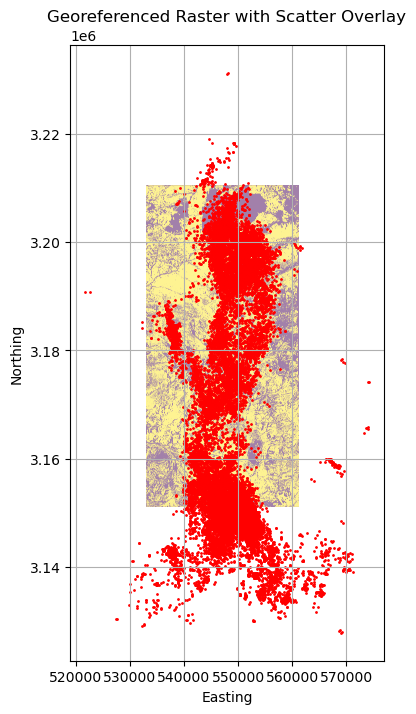

In [39]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.colors import Normalize

# Load raster
raster_path = '/Volumes/Tibet/XizangWVProcessing/Profiles/UD_velocity_merged.tif'  # Replace with your file path
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Read the first band
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Plot
plt.figure(figsize=(8, 8))

# 1. Plot raster with transparency
plt.imshow(
    raster_data,
    extent=extent,
    origin='upper',
    cmap='viridis',     # Or other colormap
    alpha=0.5,           # Transparency
    norm=Normalize(vmin=raster_data.min(), vmax=raster_data.max())
)

# 2. Scatter plot over it
plt.scatter(easting, northing, s=1, color='red')
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title("Georeferenced Raster with Scatter Overlay")
plt.grid(True)
plt.show()


## DEM Differencing

In [ ]:
scp chanagan@hw-login1.gs.doi.net:/caldera/hovenweep/projects/usgs/hazards/ehp/chanagan/Xizang/orthos.zip .

In [ ]:
prefixes = zip(['E','W','E-Olap'],['E','W','W-Olap'])
for pref1,pref2 in prefixes:
    predem = gdal.Open(f'/Volumes/Tibet/XizangWVProcessing/AmesStereoPipeline/dems/DemPre{pref1}-cropped.tif')
    pre = predem.GetRasterBand(1).ReadAsArray()
    pre[pre == predem.GetRasterBand(1).GetNoDataValue()] = np.nan
    postdem = gdal.Open(f'/Volumes/Tibet/XizangWVProcessing/AmesStereoPipeline/dems/DemPost{pref2}-asp-aligned.tif')
    post = postdem.GetRasterBand(1).ReadAsArray()
    post[post == postdem.GetRasterBand(1).GetNoDataValue()] = np.nan

    diff = post - pre
    mask = ((np.absolute(diff)>15) | (np.isnan(pre)) | (np.isnan(post)))
    diff[mask] = np.nan
    diff = diff - np.nanmean(diff)
    diff[mask] = -9999
    tt.save_geotiff(diff, f'/Volumes/Tibet/XizangWVProcessing/AmesStereoPipeline/dems/DemDiff{pref1}.tif', predem.GetGeoTransform(), predem.GetProjection(), nodata=-9999)


In [ ]:
np.nanmax(post)

In [ ]:
tt.getOverlap(gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/AmesStereoPipeline/Orthos/run-DRG-2024E.tif'),
              gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/AmesStereoPipeline/Orthos/run-DRG-2025E.tif'))

In [ ]:
ullr = [547922.0, 3151050.5, 561091.0, 3210432.0] # Upper Left, lower right coordinates

flist = ['/Volumes/Extreme SSD/XizangWVProcessing/AmesStereoPipeline/Orthos/run-DRG-2024E.tif',
        '/Volumes/Extreme SSD/XizangWVProcessing/AmesStereoPipeline/Orthos/run-DRG-2025E.tif']
rewrite = False

for im in flist:
    if rewrite == True:
        with gdal.Warp(
        f'{im[:-4]}-cropped.tif',
        im,
        srcSRS='EPSG:32645',
        dstSRS='EPSG:32645',
        outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
        dstNodata=-9999,
        format='GTiff',
        resampleAlg='near',
        xRes=0.5,
        yRes=0.5  # Use a positive value for yRes
        ) as im:
            im.FlushCache()

In [ ]:
# Align the image, then will need to transform post dem too
image_align --alignment-transform rigid run-DRG-2024E-cropped.tif run-DRG-2025E-cropped.tif -o run-DRG-2025E-cropped_aspAligned_topre.tif

Alignment transform:
Matrix3x3((1,-7.21705e-07,4.27002)(7.21705e-07,1,3.48409)(0,0,1))

gdalwarp -t_srs EPSG:32645 -tr 0.5 0.5 -te 547922.000 3151050.500 561091.000 3210433.500 run-DRG-2024E-cropped.tif run-DRG-2024E-cropped-f.tif
gdalwarp -t_srs EPSG:32645 -tr 0.5 0.5 -te 547922.000 3151050.500 561091.000 3210433.500 run-DRG-2025E-cropped_aspAligned_topre.tif run-DRG-2025E-cropped-f.tif

In [ ]:
nohup taskset -c 0-64 mm3d Mm2dPosSism run-DRG-2024E-cropped-f.tif run-DRG-2025E-cropped-f.tif CorMin=0.1 Dequant=false DirMEC='MEC_E/' &

## SSREOL OPT NOT SET YET
nohup taskset -c 0-64 mm3d Mm2dPosSism run-DRG-2024E-cropped.tif run-DRG-2025E-cropped.tif CorMin=0.1 SsResolOpt=1 Dequant=false DirMEC='MEC_E/' &


In [ ]:
# stitch together output
for dir in ['Px1','Px2']:
    im1 = gdal.Open(f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/{dir}_Num5_DeZoom1_LeChantier_Tile_0_0.tif') 
    im1data = im1.GetRasterBand(1).ReadAsArray()
    im2 = gdal.Open(f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/{dir}_Num5_DeZoom1_LeChantier_Tile_0_1.tif') 
    im2data = im2.GetRasterBand(1).ReadAsArray()
    im3 = gdal.Open(f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/{dir}_Num5_DeZoom1_LeChantier_Tile_0_2.tif') 
    im3data = im3.GetRasterBand(1).ReadAsArray()

    stack = np.concat([im1data,im2data,im3data])
    tt.save_geotiff(stack,f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/{dir}_Num5_DeZoom1_LeChantier.tif',im1.GetGeoTransform(),'')

im1 = gdal.Open(f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/Correl_LeChantier_Num_5_Tile_0_0.tif') 
im1data = im1.GetRasterBand(1).ReadAsArray()
im2 = gdal.Open(f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/Correl_LeChantier_Num_5_Tile_0_1.tif') 
im2data = im2.GetRasterBand(1).ReadAsArray()

stack = np.concat([im1data,im2data])
tt.save_geotiff(stack,f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/Correl_LeChantier_Num_5.tif',im1.GetGeoTransform(),'')

tt.micmacPostProcessing(folder=f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/',
                         prefiles=['/Volumes/Tibet/XizangWVProcessing/AmesStereoPipeline/Orthos/run-DRG-2024E-cropped-f.tif',
                                    '/Volumes/Tibet/XizangWVProcessing/AmesStereoPipeline/Orthos/run-DRG-2025E-cropped-f.tif'],#predem
                         outprefix=f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/')


In [ ]:
1/0.0008

In [ ]:
import rioxarray
import pygmt

In [ ]:
fig = pygmt.Figure()
fig.basemap(region=[87.4896,87.6273,28.4852,29.0206], projection="u45r/15c", frame=["WSen", "af"])
im = rioxarray.open_rasterio(f'/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/EWmicmac.tif')
im = im.rio.reproject('EPSG:4326')
pygmt.makecpt(cmap='polar',series=[-1,3],background='o',reverse=True)
fig.grdimage(grid=im,cmap=True)
fig.savefig("/Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/MEC_E/EWmicmac.pdf")#, georeference=True)
fig.show()

## Profiles of Displacement

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString, MultiLineString, mapping


In [ ]:
def calcSlopeFrom2Pts(x1,y1,x2,y2):
    '''calculate the slope of a line from two points and the strike of that line in degrees from X AXIS
    returns slope, strike'''
    slope = (y2-y1)/(x2-x1)
    strike = np.degrees(np.arctan(slope)) #this is not from NORTH!! this would be from the x-axis (math, not geology)
    return slope, strike

def calcAzimuthFromNorth(x1,y1,x2,y2):
    '''calculate the azimuth (strike) of a line from North using two points'''
    dx = x2 - x1
    dy = y2 - y1

    # make sure dx and dy are not zero. 
    if (dx == 0.0):
        dx = 0.000001
    if (dy == 0.0):
        dy = 0.000001

    #Calculate angle
    angle = np.degrees(np.abs(np.arctan(dy/dx))) #* (180/np.pi)))
    
    #first quadrant
    if (x2>=x1) and (y2>y1):
        azimuth = 90.0 - angle
        # print('first q')
    #second quadrant
    elif (x2>x1) and (y2<=y1):
        azimuth = angle + 90.0
        # print('second q')
    #third quadrant
    elif (x2<=x1) and (y2<y1):
        azimuth = 270.0 - angle
        # print('third q')
    #fourth quadrant
    else:
        azimuth = 270.0 + angle
        # print('fourth q')

    return azimuth
def calcPerpProfile(orig_strike, profile_length, profile_width, center_point): 
    '''calculate a profile perpendicular to a line from a fault strike and a center point.
    return the profile_line as LineString and profile_swath as Polygon
    orig_strike of fault in degrees
    profile_length in meters = TOTAL length
    profile_width in meters = TOTAL width
    center_point as (x1,y1)
    returns profile_line, profile_swath'''
    
    from shapely.geometry import Point, LineString, Polygon
    
    profile_strike = orig_strike + 90
    profile_angle = np.radians(profile_strike)
    
    # calc perp_line start point, profile_length/2 away from center point
    x = center_point[0] + (profile_length/2) * np.cos(profile_angle)
    y = center_point[1] + (profile_length/2) * np.sin(profile_angle)
    startpt = Point(x,y)
    
    # calc perp_line end point, profile_length/2 away from center point
    x = center_point[0] - (profile_length/2) * np.cos(profile_angle)
    y = center_point[1] - (profile_length/2) * np.sin(profile_angle)
    endpt = Point(x,y)
    
    profile_line = LineString([startpt,endpt])
    profile_swath = profile_line.buffer(profile_width/2,16,cap_style=3)
    return profile_line, profile_swath

def generateProfiles(shapefile_lines_path, profile_length, profile_width, profile_spacing,plot=True,verbose=False,save=False,prefix='all',folder='./'): #save_shp=False):
    '''
    generates profiles perpendicular to lines in a shapefile.
    optionally plots input shapefile lines and output profile swaths. default is plot=True. 
    
    inputs are:
    shapefile_lines_path - path location of the shapefile. shapefile must be lines. best if in a UTM coordinate system.
    profile_length - TOTAL length of the profiles in the same units as the shapefile coordinate system (i.e., m if in UTM)
    profile_width - TOTAL width of the profiles in the same units as the shapefile coordinate system (i.e., m if in UTM)
    profile_spacing - distance between each profile in the same units as the shapefile coordinate system (i.e., m if in UTM)
    
    outputs are:
    profile_swaths = geopandas geodataframe of POLYGON features, the profile swath.
    profile_lines = geopandas geodataframe of LINE features, the centerline of each profile perpendicular to the shapefile lines.
    profile_centerpts = geopandas geodataframe of POINT features, the midpoint of each profile line along the shapefile lines.
    
    exports:
    swaths, profiles, centerpts in geoJSON format
    strikes, n_profiles in np format
    
    '''
    
    print('profiles are',profile_width,'m wide,',profile_length,'m long, and',profile_spacing,'m apart')
    
    # read in shapefile lines
    lines = gpd.read_file(shapefile_lines_path)
    # Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
    lines = lines.explode(index_parts=True) # this turns multipart lines into single part lines so that profiles remain perpendicular to each line segment if it changes strike...but often doesn't work in Python and might need to do in QGIS first and use the exploded lines shapefile as input file
    lines = lines.reset_index(drop=True) # reset the index because we just added a bunch of lines
    print('CRS of shapefile:', lines.crs)
    
    # initialize geodataframes to hold ALL swath, profile, center_pt, strike info
    ## starting with empty dataframes because we don't know the total size yet
    # this throws a filterwarning that i'm ignoring that you can't initialize a gdf without a CRS...will need to fix eventually
    all_swaths = gpd.GeoDataFrame(geometry=[], crs=lines.crs)#geometry=gpd.points_from_xy(x,y)) # where x and y = np.zeros(len(lines))...but if start this way will have a bunch of nonesense/empty lines to remove later, but it didn't like it when I tried to start with one point
    all_profiles = gpd.GeoDataFrame(geometry=[], crs=lines.crs)#geometry=gpd.points_from_xy(x,y))
    all_centerpts = gpd.GeoDataFrame(geometry=[], crs=lines.crs)#geometry=gpd.points_from_xy(x,y))
    all_strikes = np.ones(len(lines),dtype=float)
    all_swath_strikes = np.array([],dtype=float)
    n_profiles= np.ones(len(lines),dtype=int)
    all_azimuths = np.ones(len(lines),dtype=float)
    
    for i, row in lines.iterrows():
        line_geom = row.geometry
        coords = list(line_geom.coords)
    
        # initialize per-line storage
        swaths_list = []
        profiles_list = []
        centerpts_list = []
        strikes_list = []
        azimuths_list = []
    
        for j in range(len(coords) - 1):
            x1, y1 = coords[j]
            x2, y2 = coords[j + 1]
            seg_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            if seg_length == 0:
                continue
            
            dx = (x2 - x1) / seg_length
            dy = (y2 - y1) / seg_length
            
            # Ensure at least one profile, even on short segments
            if seg_length < profile_spacing:
                dists = [seg_length / 2]
            else:
                dists = np.arange(profile_spacing / 2, seg_length, profile_spacing)
            
            for dist_along in dists:
                cx = x1 + dx * dist_along
                cy = y1 + dy * dist_along
            
                slope, strike = calcSlopeFrom2Pts(x1, y1, x2, y2)
                azimuth = calcAzimuthFromNorth(x1, y1, x2, y2)
            
                profile_line, profile_swath = calcPerpProfile(strike, profile_length, profile_width, (cx, cy))
            
                swaths_list.append(profile_swath)
                profiles_list.append(profile_line)
                centerpts_list.append(Point(cx, cy))
                strikes_list.append(strike)
                azimuths_list.append(azimuth)


    
        # convert lists to GeoDataFrames
        swaths = gpd.GeoDataFrame(geometry=swaths_list, crs=lines.crs)
        profiles = gpd.GeoDataFrame(geometry=profiles_list, crs=lines.crs)
        center_points = gpd.GeoDataFrame(geometry=centerpts_list, crs=lines.crs)
        center_points['fault_azimuth'] = azimuths_list  # last segment azimuth; optional: store full list
    
        all_swaths = pd.concat([all_swaths, swaths])
        all_profiles = pd.concat([all_profiles, profiles])
        all_centerpts = pd.concat([all_centerpts, center_points])
        all_swath_strikes = np.concatenate([all_swath_strikes, np.array(strikes_list)])
        all_strikes[i] = np.mean(strikes_list)
        all_azimuths[i] = np.mean(azimuths_list)
        n_profiles[i] = len(strikes_list)
    
        # reset index because otherwise the index is duplicated for each line in the shapefile
        all_swaths = all_swaths.reset_index(drop=True)
        all_profiles = all_profiles.reset_index(drop=True)
        all_centerpts = all_centerpts.reset_index(drop=True)
    
        # ensure profiles have same CRS as input shapefile
        all_swaths = all_swaths.set_crs(lines.crs)
        all_profiles = all_profiles.set_crs(lines.crs)
        all_centerpts = all_centerpts.set_crs(lines.crs)
    
    # to plot or not to plot
    if plot==True:
        fig,ax = plt.subplots(figsize=(8,8))
        all_swaths.plot(ax=ax,alpha=.2,color='k')
        all_profiles.plot(ax=ax,color='k',lw=.5)
        all_centerpts.plot(ax=ax,color='b')
        lines.plot(ax=ax,color='r',lw=.75)
        plt.show()


    if save==True:
        all_swaths.to_file(folder+'%s_swaths_%sprofiles.geojson' %(prefix,sum(n_profiles)), driver='GeoJSON') 
        all_profiles.to_file(folder+'%s_profiles_%sprofiles.geojson' %(prefix,sum(n_profiles)), driver='GeoJSON')  
        all_centerpts.to_file(folder+'%s_centerpts_%sprofiles.geojson' %(prefix,sum(n_profiles)), driver='GeoJSON') 
        np.save(folder+'%s_swath_strikes_%sprofiles.npy' %(prefix,sum(n_profiles)),all_swath_strikes, allow_pickle=True,)
        np.save(folder+'%s_strikes_%sprofiles.npy' %(prefix,sum(n_profiles)),all_strikes,allow_pickle=True,)
        np.save(folder+'%s_azimuths_%sprofiles.npy' %(prefix,sum(n_profiles)),all_azimuths,allow_pickle=True,)
        np.save(folder+'%s_n_profiles_%sprofiles.npy' %(prefix,sum(n_profiles)),n_profiles,allow_pickle=True,)



    return all_swaths, all_swath_strikes, all_profiles, all_centerpts, all_strikes, n_profiles, all_azimuths

saving profiles to:  /Volumes/Tibet/XizangWVProcessing/Profiles/
profiles are 2000 m wide, 45000 m long, and 5000 m apart
CRS of shapefile: EPSG:32645


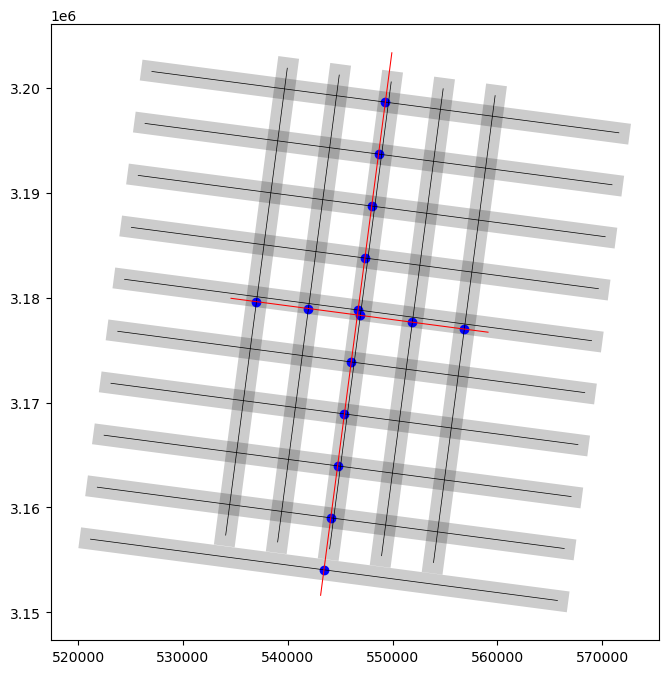

15 total profiles


In [ ]:
## MAKE PROFILES
rewrite = True

label = 'Tibet'

fault_map_path = '/Volumes/Tibet/XizangWVProcessing/GIS/ProfileGrid.geojson'
folder = '/Volumes/Tibet/XizangWVProcessing/Profiles/'

print('saving profiles to: ',folder)
fault_map = gpd.read_file(fault_map_path) # complete representation of faulting to plot


profile_length = 45000 # in meters, not pixels
pixel_res = 4 # Bill's 10m = 80 m.
profile_width = 2000 # In meters 
profile_spacing = 5000 #in meters 
prefix = 'Tibet_20250107'

swaths, swath_strikes, profiles, center_points, strikes, n_profs, azimuths = generateProfiles(fault_map_path,profile_length,profile_width,profile_spacing,save=rewrite,prefix=prefix,folder=folder)
## if get a warning about multipart geometries, use conda environment geospatial2
n_profs = np.sum(n_profs)
#strikes, n_profs
#print(len(n_profs),'exploded segments with',sum(n_profs),'total profiles')
print(len(swaths), 'total profiles')

In [ ]:
Stop
%%bash
# Merge NS, EW
gdalwarp -t_srs EPSG:32645 -tr 4 4 -srcnodata -9999 -dstnodata -9999 -overwrite -of GTiff -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES \
    /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/Ortho*-cropped_VS_Ortho*-cropped_frequency_wz_64_step_8NS_bandpassed_adjusted.tif \
    /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/NS_velocity_merged.tif
gdalwarp -t_srs EPSG:32645 -tr 4 4 -srcnodata -9999 -dstnodata -9999 -overwrite -of GTiff -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES \
    /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/Ortho*-cropped_VS_Ortho*-cropped_frequency_wz_64_step_8EW_bandpassed_adjusted.tif \
    /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/EW_velocity_merged.tif

Creating output file that is 7037P x 14856L.
Processing /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-Olap-cropped_VS_OrthoPostW-Olap-cropped_frequency_wz_64_step_8NS_bandpassed_adjusted.tif [1/3] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-cropped_VS_OrthoPostE-cropped_frequency_wz_64_step_8NS_bandpassed_adjusted.tif [2/3] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreW-cropped_VS_OrthoPostW-cropped_frequency_wz_64_step_8NS_bandpassed_adjusted.tif [3/3] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 7037P x 14856L.
Processing /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-Olap-cropped_VS_OrthoPostW-Olap-cropped_frequency_wz_64_step_8EW_bandpas

In [17]:
%%bash
gdalwarp -t_srs EPSG:32645 -tr 4 4 -srcnodata -9999 -dstnodata -9999 -overwrite -of GTiff -co COMPRESS=LZW -co ZLEVEL=9 -co BIGTIFF=YES \
    /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/Ortho*-cropped_VS_Ortho*-cropped_frequency_wz_64_step_8UD_bandpassed_adjusted.tif \
    /Volumes/Tibet/XizangWVProcessing/Profiles/UD_velocity_merged.tif

Creating output file that is 7037P x 14856L.
Processing /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-Olap-cropped_VS_OrthoPostW-Olap-cropped_frequency_wz_64_step_8UD_bandpassed_adjusted.tif [1/3] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreE-cropped_VS_OrthoPostE-cropped_frequency_wz_64_step_8UD_bandpassed_adjusted.tif [2/3] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing /Volumes/Tibet/XizangWVProcessing/Micmac/ASP50cm/CosiCorr/FrequencyResults/OrthoPreW-cropped_VS_OrthoPostW-cropped_frequency_wz_64_step_8UD_bandpassed_adjusted.tif [3/3] : 0...10...20...30...40...50...60...70...80...90...100 - done.


## Calc Profiles

In [ ]:
import rioxarray
import pygmt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erf
import h5py
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt


from pyproj import Proj, Geod
P = Proj('epsg:32645')
G = Geod(ellps='WGS84')

In [ ]:
# Functions
def fault_curve_fit(x, a, b, c, ws, m):
    '''From Milliner et al., 2021
    The solved parameters include the intercept (a), the total fault displacement (b), 
    the fault location (c), the shear width (ws), and the slope (m),'''
    return a+b/2*erf((x-c)/(ws*np.sqrt(2)))+m*x

def fault_curve_fit_noslope(x, a, b, c, ws):
    '''From Milliner et al., 2021
    The solved parameters include the intercept (a), the total fault displacement (b), 
    the fault location (c), the shear width (ws)'''
    return a+b/2*erf((x-c)/(ws*np.sqrt(2)))

def projectParPerp(ns, ew, az):
    theta = (az)*np.pi/180
    par = ns*np.cos(theta)+ew*np.sin(theta)
    perp = -1*ns*np.sin(theta)+ew*np.cos(theta)
    return par.flatten(), perp.flatten()

In [ ]:
fault_map_path = '/Volumes/Tibet/XizangWVProcessing/GIS/ProfileGrid.geojson'
folder = '/Volumes/Tibet/XizangWVProcessing/Profiles/'
profile_length = 45000 # in meters, not pixels
pixel_res = 4 # Bill's 10m = 80 m.
profile_width = 2000 # In meters 
profile_spacing = 5000 #in meters 
prefix = 'Tibet_20250107'

In [10]:
# Function to compute MAD
def mad(x):
    median = np.median(x)
    return np.median(np.abs(x - median))

0 of 15


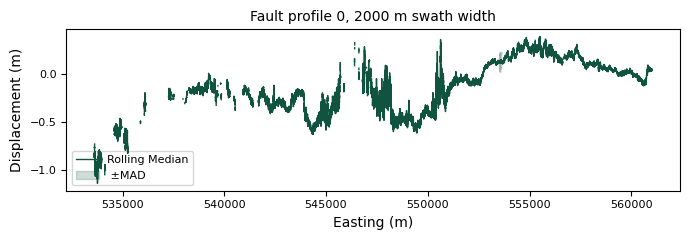

1 of 15


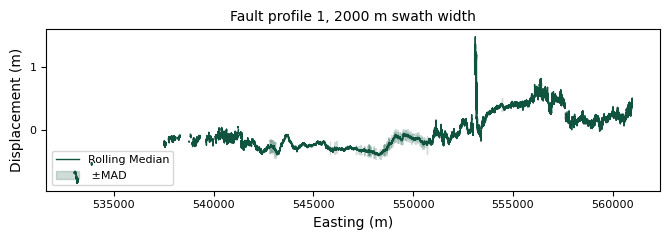

2 of 15


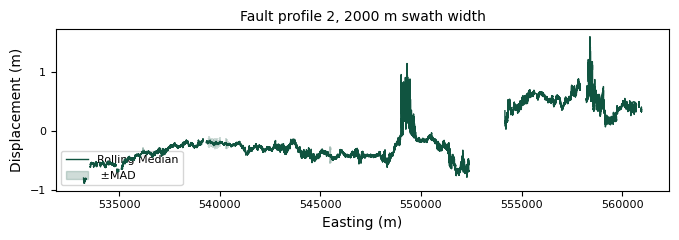

3 of 15


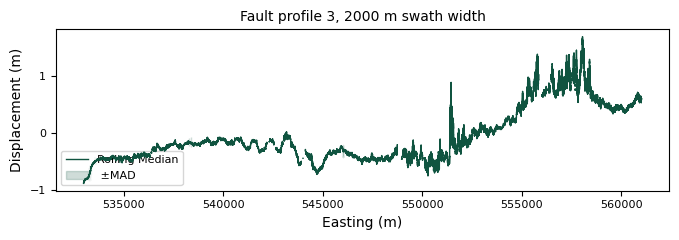

4 of 15


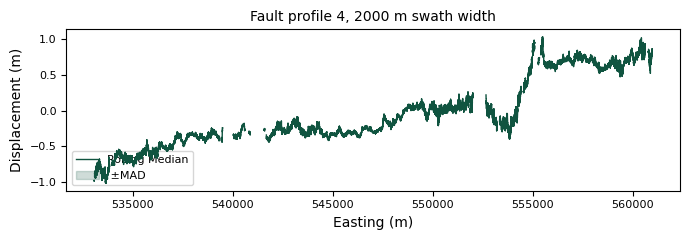

5 of 15


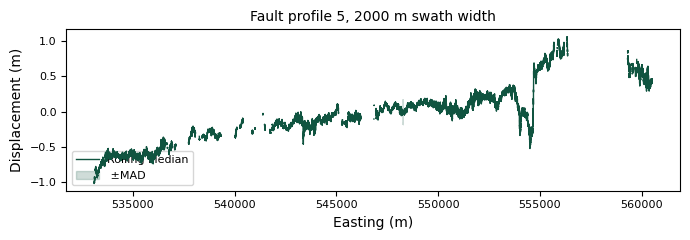

6 of 15


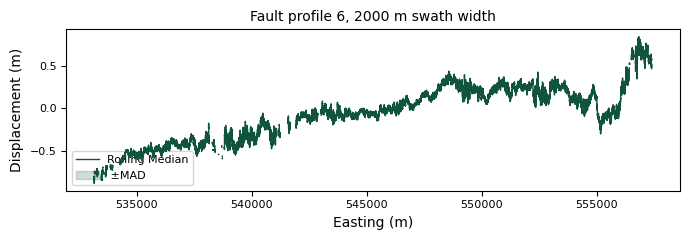

7 of 15


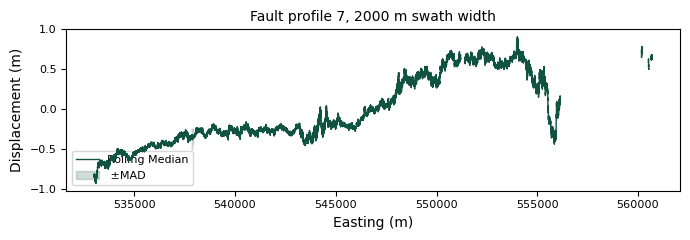

8 of 15


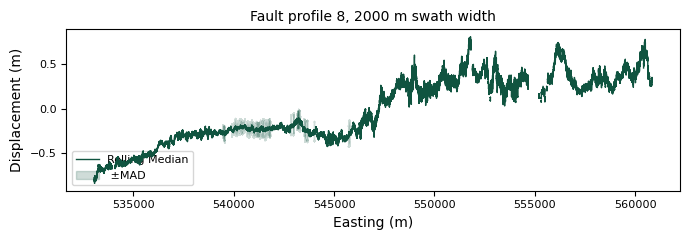

9 of 15


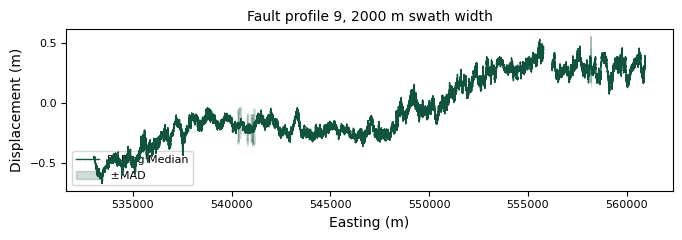

10 of 15


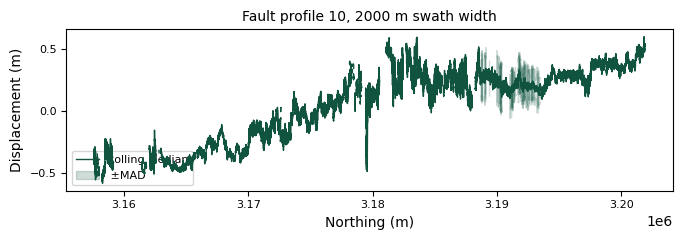

11 of 15


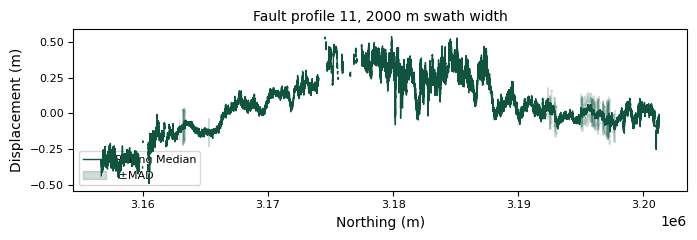

12 of 15


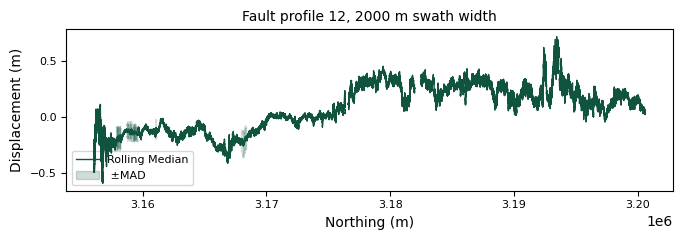

13 of 15


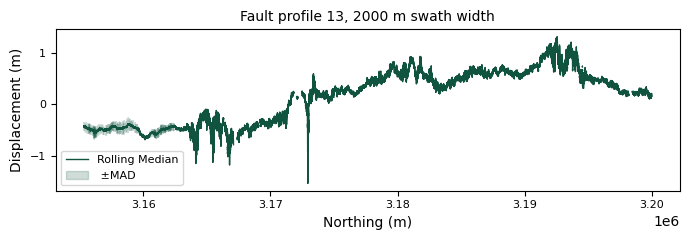

14 of 15


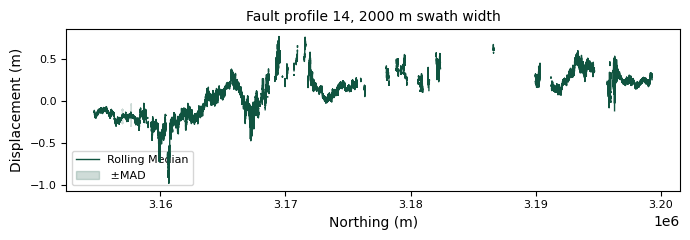

In [29]:
profile_length = profile_length  # m
swath_width = 2000       # m
resolution = pixel_res       # m

# Read in the fault points
label = 'Tibet_20250107'


points = gpd.read_file('/Volumes/Tibet/XizangWVProcessing/Profiles/Tibet_20250107_centerpts_15profiles.geojson')

points = gpd.GeoDataFrame(points)

# Read the rasters
ns = rasterio.open('/Volumes/Tibet/XizangWVProcessing/Profiles/NS_velocity_merged.tif')
ew = rasterio.open('/Volumes/Tibet/XizangWVProcessing/Profiles/EW_velocity_merged.tif')

figpath = '/Volumes/Tibet/XizangWVProcessing/Profiles/pngs/'
savepath= '/Volumes/Tibet/XizangWVProcessing/Profiles/'


for i in range(0,len(points)):
    print(i, 'of', len(points))

    lon, lat = P(points.geometry.x.iloc[i], points.geometry.y.iloc[i], inverse=True)
    lon1, lat1, _ = G.fwd(lon, lat, points.fault_azimuth.iloc[i] - 90, profile_length / 2)
    lon2, lat2, _ = G.fwd(lon, lat, points.fault_azimuth.iloc[i] + 90, profile_length / 2)
    tmppts = np.array(G.npts(lon1=lon1, lat1=lat1, lon2=lon2, lat2=lat2, npts=profile_length / resolution))

    starts = G.fwd(tmppts[:, 0], tmppts[:, 1], [points.fault_azimuth.iloc[i]] * len(tmppts), [swath_width / 2] * len(tmppts))
    ends = G.fwd(tmppts[:, 0], tmppts[:, 1], [points.fault_azimuth.iloc[i] + 180] * len(tmppts), [swath_width / 2] * len(tmppts))

    map_object = np.array(list(map(
        lambda lon1, lat1, lon2, lat2: G.npts(lon1, lat1, lon2, lat2, swath_width / resolution),
        starts[0], starts[1], ends[0], ends[1]
    )))

    pts = map_object.reshape(len(starts[0]) * int(swath_width / resolution), 2)
    pts = P(pts[:, 0], pts[:, 1])
    pts = np.column_stack(pts)
    dist = np.arange(-profile_length / 2, profile_length / 2, resolution)
    dists = np.repeat(dist, int(swath_width / resolution))

    # Northing and easting for x-label later
    if abs(np.sin(points.fault_azimuth.iloc[i]*np.pi/180)) >= np.sin(45*np.pi/180):
        # Use easting
        utm = np.repeat(P(tmppts[:,0], tmppts[:,1])[1],int(swath_width / resolution))
        xlabel= 'Northing'
    else: # use northing
        utm = np.repeat(P(tmppts[:,0], tmppts[:,1])[0],int(swath_width / resolution))
        xlabel= 'Easting'
    
    assert pts.shape[0] == dists.shape[0], "Mismatch between number of points and distances"

    ns_samps = np.array([x for x in ns.sample(pts)])
    ns_samps[ns_samps == -9999] = np.nan
    ew_samps = np.array([x for x in ew.sample(pts)])
    ew_samps[ew_samps == -9999] = np.nan

    # Calculate percentage of samples from full dataset
    valid_samps = len(ns_samps[~np.isnan(ns_samps)])/len(ns_samps.flatten())
    points.loc[i,'valid_samps_ratio'] = np.round(valid_samps,2)

    par, perp = projectParPerp(
        ns_samps - np.nanmean(ns_samps),
        ew_samps - np.nanmean(ew_samps),
        points.fault_azimuth.iloc[i]
    )

    # Calculate rolling medians
    window = int(swath_width/resolution)
    min_periods = int(window/2)
    par_rolling = pd.DataFrame(par).rolling(window=window,center=True,min_periods=min_periods).median()
    par_rolling_mad = pd.DataFrame(par).rolling(window=window,center=True,min_periods=min_periods).apply(mad,raw=True)

    perp_rolling = pd.DataFrame(perp).rolling(window=window,center=True,min_periods=min_periods).median()
    perp_rolling_mad = pd.DataFrame(perp).rolling(window=window,center=True,min_periods=min_periods).apply(mad,raw=True)

    plt.figure(figsize=(7, 2.5))
    plt.style.use('seaborn-v0_8-colorblind')

    # Scatter points
    #plt.scatter(dists, perp, s=2, c='#E69F00', label='Perpendicular data')
    #plt.scatter(dists, par, s=2, c='#1B9E77', label='Parallel data')

    # Plot rolling
    #plt.plot(
    #    dists,
    #    par_rolling,
    #    color="#105440",
    #    linewidth=1,
    #    label=f'Rolling Median',
    #    zorder=7
    #)
    ## Plot shaded MAD bounds
    #plt.fill_between(
    #    dists,
    #    (par_rolling - par_rolling_mad).values.flatten(),
    #    (par_rolling + par_rolling_mad).values.flatten(),
    #    color="#105440",
    #    alpha=0.2,
    #    label=f" ±MAD"
    #)

        # Plot rolling
    plt.plot(
        utm,
        perp_rolling,
        color="#105440",
        linewidth=1,
        label=f'Rolling Median',
        zorder=7
    )
    # Plot shaded MAD bounds
    plt.fill_between(
        utm,
        (perp_rolling - perp_rolling_mad).values.flatten(),
        (perp_rolling + perp_rolling_mad).values.flatten(),
        color="#105440",
        alpha=0.2,
        label=f" ±MAD"
    )
        

    # Offset text to display later
    offset_text = ""


    # Offset annotation text
    plt.text(0.98, 0.95, offset_text.strip(),
     fontsize=8,
     ha='right', va='top',
     transform=plt.gca().transAxes,
     bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

    # Plot styling
    plt.xlabel(f'{xlabel} (m)', fontsize=10)
    plt.ylabel('Displacement (m)', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend( fontsize=8, loc='lower left')
    plt.title(f'Fault profile {i}, {swath_width} m swath width', fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{figpath}Profile{i}_{len(points)}_ProfLen{profile_length}_SwathWidth{swath_width}_{label}.png', dpi=300)
    plt.show()
points['easting'] = points.geometry.x
points['northing'] = points.geometry.y
# Save results
# points.to_csv(
 #    f'{savepath}ErfProfileResults_ProfLen{profile_length}_SwathWidth{swath_width}_{label}.csv'

In [58]:
G.fwd(lon, lat, points.fault_azimuth.iloc[i], profile_length/resolution)

(87.49331817326366, 28.836627913287508, -172.51188659785754)

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_73314/3328576001.py:19: SyntaxWarning: invalid escape sequence '\s'
  depth_pts = pd.read_csv('/Volumes/Tibet/XizangWVProcessing/SupportingData/relocated_aftershocks_20250108-20250118.txt',sep='\s+',skiprows=2)


10 of 15


<Figure size 700x250 with 0 Axes>

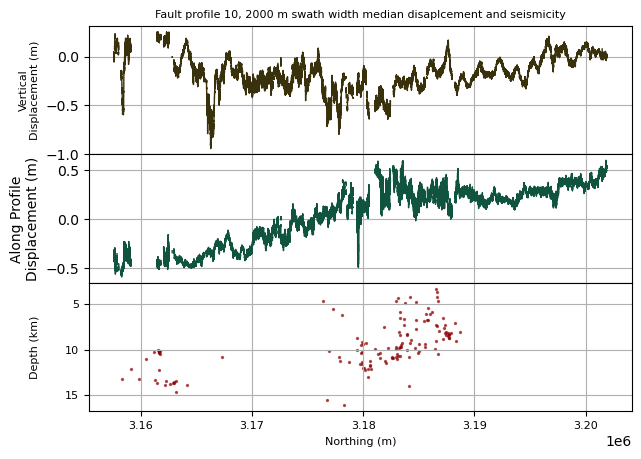

11 of 15


<Figure size 700x250 with 0 Axes>

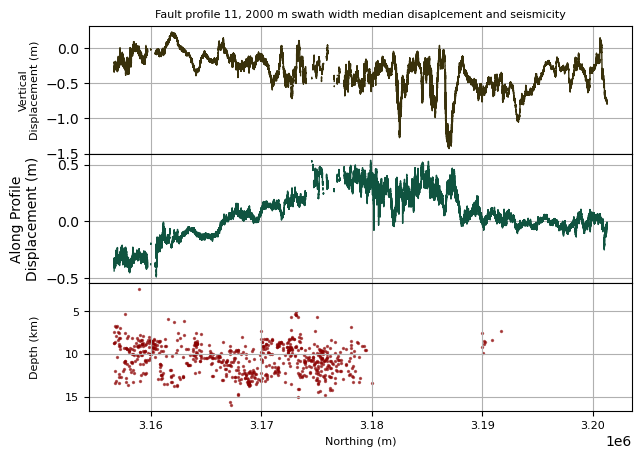

12 of 15


<Figure size 700x250 with 0 Axes>

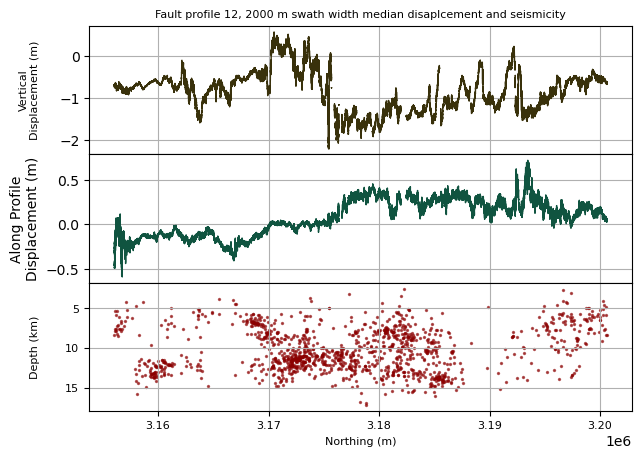

13 of 15


<Figure size 700x250 with 0 Axes>

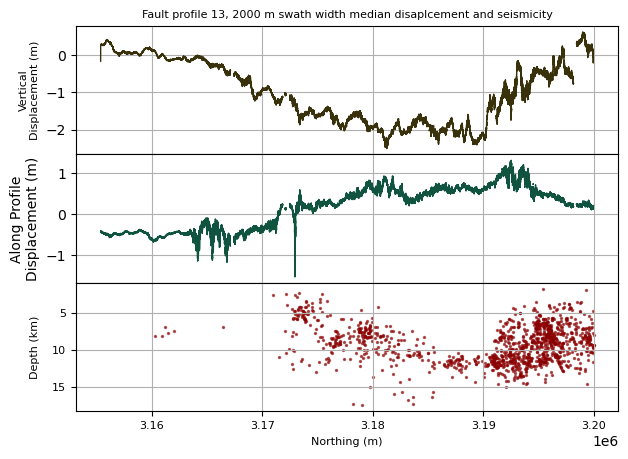

14 of 15


<Figure size 700x250 with 0 Axes>

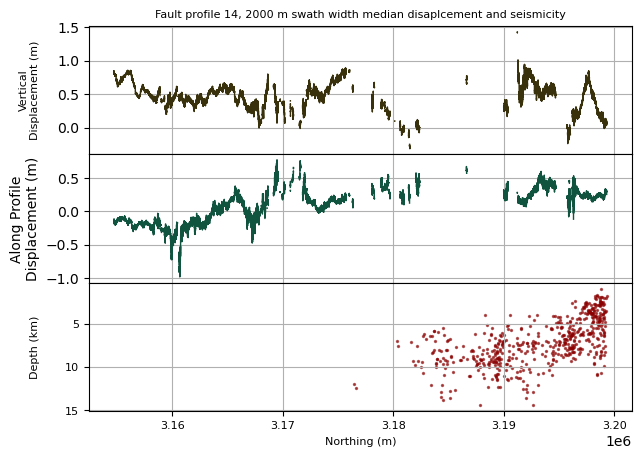

In [73]:
profile_length = profile_length  # m
swath_width = 2000      # m
resolution = pixel_res       # m

# Read in the fault points
label = 'Tibet_20250107'


points = gpd.read_file('/Volumes/Tibet/XizangWVProcessing/Profiles/Tibet_20250107_centerpts_15profiles.geojson')

points = gpd.GeoDataFrame(points)

# Read the rasters
ns = rasterio.open('/Volumes/Tibet/XizangWVProcessing/Profiles/NS_velocity_merged.tif')
ew = rasterio.open('/Volumes/Tibet/XizangWVProcessing/Profiles/EW_velocity_merged.tif')
ud = rasterio.open('/Volumes/Tibet/XizangWVProcessing/Profiles/UD_velocity_merged.tif')

# Seismicity
depth_pts = pd.read_csv('/Volumes/Tibet/XizangWVProcessing/SupportingData/relocated_aftershocks_20250108-20250118.txt',sep='\s+',skiprows=2)
depth_pts['easting'], depth_pts['northing'] = P(depth_pts['longitude'],depth_pts['latitude'])

figpath = '/Volumes/Tibet/XizangWVProcessing/Profiles/pngs/'
savepath= '/Volumes/Tibet/XizangWVProcessing/Profiles/'

results_list = []  # We'll collect dictionaries here and build a DataFrame after the loop

for i in range(10,len(points)):#range(0,len(points)):
    print(i, 'of', len(points))

    lon, lat = P(points.geometry.x.iloc[i], points.geometry.y.iloc[i], inverse=True)
    lon1, lat1, _ = G.fwd(lon, lat, points.fault_azimuth.iloc[i] - 90, profile_length / 2)
    lon2, lat2, _ = G.fwd(lon, lat, points.fault_azimuth.iloc[i] + 90, profile_length / 2)
    tmppts = np.array(G.npts(lon1=lon1, lat1=lat1, lon2=lon2, lat2=lat2, npts=profile_length / resolution))

    starts = G.fwd(tmppts[:, 0], tmppts[:, 1], [points.fault_azimuth.iloc[i]] * len(tmppts), [swath_width / 2] * len(tmppts))
    ends = G.fwd(tmppts[:, 0], tmppts[:, 1], [points.fault_azimuth.iloc[i] + 180] * len(tmppts), [swath_width / 2] * len(tmppts))

    map_object = np.array(list(map(
        lambda lon1, lat1, lon2, lat2: G.npts(lon1, lat1, lon2, lat2, swath_width / resolution),
        starts[0], starts[1], ends[0], ends[1]
    )))

    pts = map_object.reshape(len(starts[0]) * int(swath_width / resolution), 2)
    pts = P(pts[:, 0], pts[:, 1])
    pts = np.column_stack(pts)
    dist = np.arange(-profile_length / 2, profile_length / 2, resolution)
    dists = np.repeat(dist, int(swath_width / resolution))

    # Northing and easting for x-label later
    if abs(np.sin(points.fault_azimuth.iloc[i]*np.pi/180)) >= np.sin(45*np.pi/180):
        # Use easting
        utm = np.repeat(P(tmppts[:,0], tmppts[:,1])[1],int(swath_width / resolution))
        xlabel= 'Northing'
    else: # use northing
        utm = np.repeat(P(tmppts[:,0], tmppts[:,1])[0],int(swath_width / resolution))
        xlabel= 'Easting'
    
    assert pts.shape[0] == dists.shape[0], "Mismatch between number of points and distances"

    ### seismicity
    # Create unit vectors
    az_rad = np.deg2rad(points.fault_azimuth.iloc[i])
    dx = np.cos(az_rad)
    dy = np.sin(az_rad)

    # Vectors from profile center
    rel_e = depth_pts.easting.values - points.geometry.x.iloc[i]
    rel_n = depth_pts.northing.values - points.geometry.y.iloc[i]
    
    # Project onto perpendicular axis (distance from centerline)
    along_dist = rel_e * dx + rel_n * dy
    perp_dist = -rel_e * dy + rel_n * dx
    
    # Filter seismicity points inside swath
    mask = (
        (np.abs(perp_dist) <= swath_width / 2) &
        (np.abs(along_dist) <= profile_length / 2)
    )

    seis_swath = depth_pts[mask].copy()

    ### Sample rasters
    ns_samps = np.array([x for x in ns.sample(pts)])
    ns_samps[ns_samps == -9999] = np.nan
    ew_samps = np.array([x for x in ew.sample(pts)])
    ew_samps[ew_samps == -9999] = np.nan
    ud_samps = np.array([x for x in ud.sample(pts)])
    ud_samps[ud_samps == -9999] = np.nan

    par, perp = projectParPerp(
        ns_samps - np.nanmean(ns_samps),
        ew_samps - np.nanmean(ew_samps),
        points.fault_azimuth.iloc[i]
    )

    # Calculate rolling medians
    window = int(swath_width/resolution)
    min_periods = int(window/2)
    #par_rolling = pd.DataFrame(par).rolling(window=window,center=True,min_periods=min_periods).median()
    #par_rolling_mad = pd.DataFrame(par).rolling(window=window,center=True,min_periods=min_periods).apply(mad,raw=True)

    perp_rolling = pd.DataFrame(perp).rolling(window=window,center=True,min_periods=min_periods).median()
    perp_rolling_mad = pd.DataFrame(perp).rolling(window=window,center=True,min_periods=min_periods).apply(mad,raw=True)
    vert_rolling = pd.DataFrame(ud_samps).rolling(window=window,center=True,min_periods=min_periods).median()
    vert_rolling_mad = pd.DataFrame(ud_samps).rolling(window=window,center=True,min_periods=min_periods).apply(mad,raw=True)
    
    plt.figure(figsize=(7, 2.5))
    plt.style.use('seaborn-v0_8-colorblind')


    fig, (ax1, ax2, ax3) = plt.subplots(
        nrows=3, ncols=1, figsize=(7, 5), sharex=True,
        gridspec_kw={'hspace': 0}
    )
    plt.style.use('seaborn-v0_8-colorblind')

    # --- Plot VERTICAL (UD) ---
    ax1.plot(
        utm,
        vert_rolling,
        color="#39310B",
        linewidth=1,
        #label='Vertical Rolling Median',
        zorder=7
    )
    #ax1.fill_between(
    #    utm,
    #    (vert_rolling - vert_rolling_mad).values.flatten(),
    #    (vert_rolling + vert_rolling_mad).values.flatten(),
    #    color="#544710",
    #    alpha=0.2,
    #    label='±MAD'
    #)
    ax1.set_ylabel('Vertical\nDisplacement (m)', fontsize=8)
    ax1.tick_params(axis='x', labelbottom=False)
    #ax1.legend(fontsize=8, loc='lower left')
    ax1.set_title(f'Fault profile {i}, {swath_width} m swath width median disaplcement and seismicity', fontsize=8)
    ax1.grid(True)

    # --- Plot PERPENDICULAR ---
    ax2.plot(
        utm,
        perp_rolling,
        color="#105440",
        linewidth=1,
        label='Along Profile Rolling Median',
        zorder=7
    )
    #ax2.fill_between(
    #    utm,
    #    (perp_rolling - perp_rolling_mad).values.flatten(),
    #    (perp_rolling + perp_rolling_mad).values.flatten(),
    #    color="#105440",
    #    alpha=0.2,
    #    label='±MAD'
    #)
    ax2.set_ylabel('Along Profile\nDisplacement (m)', fontsize=10)
    ax2.set_xlabel(f'{xlabel} (m)', fontsize=8)
    #ax2.legend(fontsize=8, loc='lower left')
    ax2.grid(True)

    # Plot image boundaries: 
    if xlabel == 'Easting':
        ax1.axvline(548547.496,linestyle=':',c='grey',zorder=1)
        ax2.axvline(548547.496,linestyle=':',c='grey',zorder=1)
        ax1.axvline(543379.578,linestyle=':',c='grey',zorder=1)
        ax2.axvline(543379.578,linestyle=':',c='grey',zorder=1)

        seisx = seis_swath.easting
    else:
        seisx = seis_swath.northing

    # --- Plot DEPTH CROSS SECTION ---
    ax3.scatter(
        seisx,
        seis_swath.depth,
        s=2, color='darkred', alpha=0.6
    )
    ax3.invert_yaxis()  # depth increases down
    ax3.set_ylabel("Depth (km)", fontsize=8)
    ax3.set_xlabel(f"{xlabel} (m)", fontsize=8)
    #ax3.set_title("Depth Cross Section (Seismicity)", fontsize=9)
    ax3.grid(True)

    # Optional offset annotation (same as your original)
    offset_text = ""
    ax1.text(0.98, 0.95, offset_text.strip(),
             fontsize=8, ha='right', va='top',
             transform=ax1.transAxes,
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    fig.align_ylabels([ax1, ax2, ax3])
    plt.savefig(f'{figpath}Profile{i}_{len(points)}_ProfLen{profile_length}_SwathWidth{swath_width}_{label}.svg', dpi=300)
    plt.show()

    # Store each UTM row in the results list with corresponding values
    for j in range(len(utm)):
        results_list.append({
            'profile_id': i,
            'utm': utm[j],
            'perp_median': perp_rolling.iloc[j, 0],
            'perp_mad': perp_rolling_mad.iloc[j, 0],
            'vert_median': vert_rolling.iloc[j, 0],
            'vert_mad': vert_rolling_mad.iloc[j, 0]
        })

    
results_df = pd.DataFrame(results_list)

# Save results
results_df.to_csv(
    f'{savepath}ProfileRollingStats_ProfLen{profile_length}_SwathWidth{swath_width}_{label}.csv',
    index=False
)


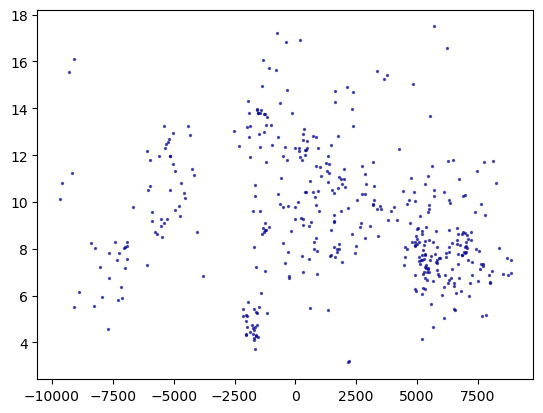

In [ ]:
plt.scatter(
        depth_poi, 
        -1*depth_pts_swath['depth'], 
        s=2, color='darkblue', alpha=0.6
    )

## Stereo WV 2 m

In [ ]:
from osgeo import gdal

rewrite = False

flist = ['/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/OrthosWith2mDem/24JAN16050706-P1BS-050278578010_01_P001-ortho.tif',
            '/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/OrthosWith2mDem/25FEB26080048-P1BS-050299533010_01_P001-ortho.tif']

flist = ['/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/DEMs/XizangDEM_2m_20240116_WV2Strip.tif',
         '/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/DEMs/XizangDEM_2m_20250126_WV2Strip.tif']


ullr = [548030.4,3212449.8,561443.2,3150925.5] # Upper Left, lower right coordinates

for im in flist:
    if rewrite == True:
        with gdal.Warp(
        f'{im[:-4]}-cropped.tif',
        im,
        srcSRS='EPSG:32645',
        dstSRS='EPSG:32645',
        outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
        srcNodata=0,
        dstNodata=-9999,
        format='GTiff',
        outputType=gdal.GDT_Int16,
        resampleAlg='near',
        xRes=1.0,
        yRes=1.0  # Use a positive value for yRes
        ) as im:
            im.FlushCache()



In [ ]:
from osgeo import gdal
import numpy as np

def rescale_and_merge_tifs(flist, output_tif, ullr, new_min=0, new_max=65535, nodata=None, rewrite=True):
    """
    Rescales and merges a list of GeoTIFF files using GDAL.

    Parameters:
    - flist (list): List of input GeoTIFF file paths.
    - output_tif (str): Path to output merged and rescaled GeoTIFF.
    - new_min (float): New minimum brightness value.
    - new_max (float): New maximum brightness value.
    - rewrite (bool): If True, overwrites existing merged TIFF.
    """
    # First, rescale all individual images before merging
    rescaled_files = []
    for i, input_tif in enumerate(flist):
        rescaled_tif = input_tif.replace('.tif', '-rescaled.tif')
        
        ds = gdal.Open(input_tif, gdal.GA_ReadOnly)
        band = ds.GetRasterBand(1)
        if nodata == None:
            nodata = band.GetNoDataValue()

        # Read data
        img = band.ReadAsArray().astype(np.uint16)

        # Mask NoData values
        valid_mask = (img != nodata)
        
        # Compute min/max only for valid pixels
        img_min, img_max = np.percentile(img[valid_mask], [2, 98])  # Use 2-98% percentile for robustness
        
        # Rescale data
        img_rescaled = new_min + (img - img_min) * ((new_max - new_min) / (img_max - img_min))
        img_rescaled = np.clip(img_rescaled, new_min, new_max)  # Ensure values stay within range
        img_rescaled[~valid_mask] == nodata

        # Write rescaled file
        driver = gdal.GetDriverByName("GTiff")
        out_ds = driver.Create(rescaled_tif, ds.RasterXSize, ds.RasterYSize, 1, gdal.GDT_Float32)
        out_ds.SetGeoTransform(ds.GetGeoTransform())
        out_ds.SetProjection(ds.GetProjection())

        out_band = out_ds.GetRasterBand(1)
        out_band.WriteArray(img_rescaled)
        out_band.SetNoDataValue(nodata)
        out_band.FlushCache()

        ds, out_ds = None, None
        rescaled_files.append(rescaled_tif)
        print(f"Rescaled {input_tif} → {rescaled_tif}")

    # Merge rescaled files
    if rewrite:
        print("Merging rescaled images...")
        with gdal.Warp(
            output_tif,
            rescaled_files,
            srcSRS='EPSG:32645',
            dstSRS='EPSG:32645',
            outputBounds=[ullr[0], ullr[3], ullr[2], ullr[1]],
            srcNodata=nodata,
            dstNodata=-9999,
            format='GTiff',
            outputType=gdal.GDT_Float32,
            resampleAlg='near',
            xRes=1.0,
            yRes=1.0
        ) as im:
            im.FlushCache()
        print(f"Merged image saved to {output_tif}")

# Example Usage:
flist = ['/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/22DEC11080356-P1BS-050299531010_01_P002-ortho1m.tif',
            '/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/24JAN16050550-P1BS-050278578010_01_P002-ortho1m.tif']
#flist = ['/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/25FEB26080157-P1BS-050299530010_01_P002-ortho1m.tif',
#         '/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/25FEB26080048-P1BS-050299533010_01_P001-ortho1m.tif']

ullr = [532936,3210487,561104.9,3151032.9] # Upper Left, lower right coordinates

#rescale_and_merge_tifs(flist, "/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/TibetPre1m-merged.tif",ullr,nodata=0,rewrite=True)

nohup taskset -c 0-64 mm3d Mm2dPosSism TibetPre1m-merged.tif TibetPost1m-merged.tif CorMin=0.1 Dequant=false DirMEC='MEC_Tibet1mDEM/' &



In [ ]:
nohup taskset -c 0-64 mm3d Mm2dPosSism 24JAN16050706-P1BS-050278578010_01_P001-ortho-cropped.tif 25FEB26080048-P1BS-050299533010_01_P001-ortho-cropped.tif CorMin=0.1 Dequant=false DirMEC='MEC_Tibet2mOrtho/' &
nohup taskset -c 0-64 mm3d Mm2dPosSism XizangDEM_2m_20240116_WV2Strip-cropped.tif XizangDEM_2m_20250126_WV2Strip-cropped.tif CorMin=0.1 Dequant=false DirMEC='MEC_Tibet2mDEM/' &


In [ ]:
Dont run again
tt.micmacPostProcessing(folder='/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet1mDEM/',
                         prefiles=['/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/TibetPost1m-merged.tif',
                                   '/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/TibetPre1m-merged.tif'],
                         outprefix='/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet1mDEM/')

In [ ]:
imf = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet1mDEM/NSmicmac.tif'
im = gdal.Open(imf)
nodata = im.GetRasterBand(1).GetNoDataValue()
imdata = im.GetRasterBand(1).ReadAsArray()
imdata[imdata == nodata] = np.nan

In [ ]:
meds = np.nanmedian(imdata,axis=0)

In [ ]:
plt.plot(meds.di)

In [ ]:
# Step 2: Compute Row-Wise Average
y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values
y[np.isnan(y)] = 0
# Step 3: Apply Low-Pass Filter
b, a = signal.butter(order, cutoffs, fs=fs, btype='band', analog=False)
yfilt = signal.filtfilt(b, a, y)
yfilt[y==0] = np.nan

In [ ]:
plt.imshow(deoffset,vmin=-2,vmax=2)

In [ ]:
# Manually determine offsets around the vertical lines



#tt.save_geotiff(destriped,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5.tif',
#                im.GetGeoTransform(),im.GetProjection())


In [ ]:
tt.save_geotiff(deoffset,f'{imf[:-4]}-column_fixed.tif',
              im.GetGeoTransform(),im.GetProjection())

In [ ]:
import numpy as np
from scipy import signal

def apply_edge_window_2d(chunk, mask, window_type='hann', edge_ratio=0.1):
    """
    Apply a window function to the edges of a 2D chunk while handling masked arrays.
    """
    rows, cols = chunk.shape
    window_rows = int(rows * edge_ratio)
    window_cols = int(cols * edge_ratio)

    if window_type == 'hann':
        window_row = np.hanning(2 * window_rows)
        window_col = np.hanning(2 * window_cols)
    elif window_type == 'hamming':
        window_row = np.hamming(2 * window_rows)
        window_col = np.hamming(2 * window_cols)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    window_row = np.concatenate([window_row[:window_rows], np.ones(rows - 2 * window_rows), window_row[window_rows:]])
    window_col = np.concatenate([window_col[:window_cols], np.ones(cols - 2 * window_cols), window_col[window_cols:]])

    window_2d = np.outer(window_row, window_col)

    # Apply window only to valid data (ignore NoData/masked)
    windowed_chunk = np.where(mask, chunk, chunk * window_2d)

    return windowed_chunk

def create_filter(filter_type, cutoff_low, cutoff_high, order):
    """
    Create a Butterworth filter based on the specified type and cutoff frequencies.
    """
    if filter_type == 'high':
        b, a = signal.butter(order, cutoff_high, btype='high')
    elif filter_type == 'low':
        b, a = signal.butter(order, cutoff_low, btype='low')
    elif filter_type == 'band':
        b, a = signal.butter(order, [cutoff_low, cutoff_high], btype='band')
    else:
        raise ValueError(f"Unsupported filter type: {filter_type}")
    return b, a

def process_image(image, nodata_value=None, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1, row_order=4,
                  col_filter_type='band', col_cutoff_low=0.001, col_cutoff_high=0.1, col_order=4,
                  stripw=1000, window_type='hann', edge_ratio=0.1):
    """
    Process the image to remove satellite stripes and waves while preserving
    long-wavelength fault deformation and near-fault offsets.
    """
    # Convert to masked array
    if nodata_value is not None:
        mask = (image == nodata_value)
        image = np.ma.masked_array(image, mask=mask)
    else:
        mask = np.isnan(image)
        image = np.ma.masked_array(image, mask=mask)

    # Create filters
    if row_filter_type is not None:
        b_row, a_row = create_filter(row_filter_type, row_cutoff_low, row_cutoff_high, row_order)
    if col_filter_type is not None:
        b_col, a_col = create_filter(col_filter_type, col_cutoff_low, col_cutoff_high, col_order)

    # Initialize arrays
    chunk_filtered_col = np.zeros_like(image, dtype=np.float32)
    chunk_filtered_row = np.zeros_like(image, dtype=np.float32)
    
    if row_filter_type is not None:
        # Process in row chunks
        for start_row in range(0, image.shape[0], int(stripw / 4)):  
            end_row = min(start_row + stripw, image.shape[0])
            chunk = image[start_row:end_row, :]

            # Apply windowing
            chunk = apply_edge_window_2d(chunk, chunk.mask, window_type, edge_ratio)

            # Sum along columns while ignoring NaNs
            signal_row = np.ma.filled(np.ma.sum(chunk, axis=0), np.ma.median(chunk, axis=0))

            # If all values are 0 (masked), skip filtering
            if np.all(signal_row == 0):
                continue

            # Apply filter
            filter_row = signal.filtfilt(b_row, a_row, signal_row)

            # Subtract from each row
            chunk_filtered_row[start_row:end_row, :] = filter_row[np.newaxis, :] / (end_row - start_row)

    if col_filter_type is not None:
        # Process in column chunks
        for start_col in range(0, image.shape[1], int(stripw / 4)):
            end_col = min(start_col + stripw, image.shape[1])
            chunk = image[:, start_col:end_col]

            # Apply windowing
            chunk = apply_edge_window_2d(chunk.T, chunk.mask.T, window_type, edge_ratio).T

            # Sum along rows while ignoring NaNs
            signal_col = np.ma.filled(np.ma.sum(chunk, axis=1), 0, np.ma.median(chunk, axis=0))

            # If all values are 0 (masked), skip filtering
            if np.all(signal_col == 0):
                continue

            # Apply filter
            filter_col = signal.filtfilt(b_col, a_col, signal_col)

            # Subtract from each column
            chunk_filtered_col[:, start_col:end_col] = filter_col[:, np.newaxis] / (end_col - start_col)

    # Combine results while keeping NoData regions untouched
    filtered_image = np.ma.array(image - chunk_filtered_row - chunk_filtered_col, mask=mask)

    return filtered_image



In [ ]:
print('Bandpass filtering')
filtered = process_image(imdata, nodata_value=np.nan,row_filter_type='band', row_cutoff_low=0.0001, row_cutoff_high=0.1,row_order=4,
                  col_filter_type=None, col_cutoff_low=0.00001, col_cutoff_high=0.0001, col_order=2,
                  stripw=1000, window_type='hann', edge_ratio=0.1)

In [ ]:
np.nanmax(filtered)

In [ ]:
plt.imshow(filtered) 


In [ ]:
plt.plot(medianrows,label='column-wise median')
plt.plot(yfilt,label='column-wise long-wavelength')
plt.plot(remove_col_offsets,label='removed')
plt.legend()

In [ ]:
tt.save_geotiff(imdata-remove_col_offsets,f'{imf[:-4]}-column_fixed.tif',
                im.GetGeoTransform(),im.GetProjection())

In [ ]:
plt.imshow(imdata-remove_col_offsets)

In [ ]:
Delete?
# nodata is reset to another value, change:
ds = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/CorreldispStacked.tif', gdal.GA_Update)
band = ds.GetRasterBand(1)
band.SetNoDataValue(-9999)
band.FlushCache()
ds = None

In [ ]:
from scipy import signal
from scipy import ndimage

def rotate_longwave_remove(data, cutoffs=[0.01,0.0001], fs=1, order=4, angle=0, nodata=np.nan):
    """
    Rotate data do stripes are horizontal, average signal along rows, 
    low pass filter the average, remove low pass from the average, 
    remove the remaining average from the rows,
    restore the image to its original dimensions.

    Parameters:
    - data: 2D numpy array (input image)
    - cutoff: float (cutoff frequency for low-pass filter)
    - fs: float (sampling frequency for filter)
    - order: int (order of the Butterworth filter)
    - angle: float (rotation angle in degrees)
    - nodata: float or np.nan (value to treat as NoData)

    Returns:
    - unrotated_data: 2D numpy array (filtered image with original dimensions)
    - filt_data: 2D numpy array (intermediate rotated and filtered image)
    """

    # Step 1: Rotate Image
    rotated_data = ndimage.rotate(data, angle=angle, reshape=True, order=1, mode="constant", cval=nodata)
    
    # Replace NoData values with NaN
    rotated_data[rotated_data == nodata] = np.nan
    
    # Step 2: Compute Row-Wise Average
    y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values
    y[np.isnan(y)] = 0

    # Step 3: Apply Low-Pass Filter
    b, a = signal.butter(order, cutoffs, fs=fs, btype='band', analog=False)
    yfilt = signal.filtfilt(b, a, y)
    yfilt[y==0] = np.nan

    # Step 4: Remove Low-Frequency Stripes
    filt_data = rotated_data - (yfilt)[:, None]

    # Step 5: Rotate Back
    unrotated_data = ndimage.rotate(filt_data, angle=-angle, reshape=True, order=1, mode="constant", cval=nodata)

    # Step 6: Crop to Original Size
    center_x, center_y = np.array(unrotated_data.shape) // 2
    orig_x, orig_y = np.array(data.shape) // 2
    cropped_data = unrotated_data[
        center_x - orig_x : center_x + orig_x,
        center_y - orig_y : center_y + orig_y
    ]

    # Step 7: Ensure Final Shape Matches Original
    if cropped_data.shape != data.shape:
        pad_x = max(0, data.shape[0] - cropped_data.shape[0])
        pad_y = max(0, data.shape[1] - cropped_data.shape[1])
        cropped_data = np.pad(cropped_data, ((0, pad_x), (0, pad_y)), mode='constant', constant_values=nodata)

    cropped_data[cropped_data == np.nan] = nodata

    # Step 8: Visualization (Optional)
    x = np.arange(len(y))
    plt.plot(x, y, label='Original')
    plt.plot(x, yfilt, label='Remove')
    plt.legend()
    plt.show()

    return cropped_data# Return both for analysis
file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/EWmicmac.tif'
#file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/EWmicmac.tif'
file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/EWdispStacked.tif'
im = gdal.Open(file)
imdata = im.GetRasterBand(1).ReadAsArray()
destriped = rotate_longwave_remove(imdata,cutoffs=[0.00001,0.0001], fs=1, order=2, angle=0,nodata=-9999)
tt.save_geotiff(destriped,f'{file[:-4]}-dewaved.tif',
                im.GetGeoTransform(),im.GetProjection())

file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/NSmicmac.tif'
#file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/NSmicmac.tif'
file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/NSdispStacked.tif'
im = gdal.Open(file)
imdata = im.GetRasterBand(1).ReadAsArray()
destriped = rotate_longwave_remove(imdata,cutoffs=[0.00001,0.0001], fs=1, order=2, angle=0,nodata=-9999)
tt.save_geotiff(destriped,f'{file[:-4]}-dewaved.tif',
                im.GetGeoTransform(),im.GetProjection())

In [ ]:
# Step 2: Compute Row-Wise Average
y = np.nanmean(imdata,axis=1)  # Use nanmean to ignore NoData values
y[np.isnan(y)] = 0
# Step 3: Apply Low-Pass Filter
b, a = signal.butter(2, [0.00001,0.0001], fs=1, btype='band', analog=False)
yfilt = signal.filtfilt(b, a, y)
yfilt[y==0] = np.nan
# Step 8: Visualization (Optional)
x = np.arange(len(y))
plt.plot(x, y, label='Original')
plt.plot(x, yfilt, label='Remove')
plt.legend()
plt.show()


In [ ]:
file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/NSmicmac.tif'
im = gdal.Open(file)
imdata = im.GetRasterBand(1).ReadAsArray()
destriped = rotate_stripe_remove(imdata, lowpass_filter=False,angle=0,nodata=-9999)
tt.save_geotiff(destriped,f'{file[:-4]}-destriped.tif',
                im.GetGeoTransform(),im.GetProjection())

## Other sections

In [ ]:
P = Proj('epsg:32645')
G = Geod(ellps='WGS84')

P(87.3499677, 29.1234285), P(87.6699452,28.3643041)

In [ ]:
# Planet Ortho, Analytic MS product
gdal_merge -ul_lr 534046.3689235895 3221711.168225529 565648.6703554555 3137741.617599279 20250102_042319_67_24b9_3B_AnalyticMS.tif 20250102_042321_66_24b9_3B_AnalyticMS.tif 20250102_042323_66_24b9_3B_AnalyticMS.tif 20250102_042325_65_24b9_3B_AnalyticMS.tif 20250102_042327_64_24b9_3B_AnalyticMS.tif 20250102_042329_63_24b9_3B_AnalyticMS.tif 20250102_042620_89_24ce_3B_AnalyticMS.tif 20250102_042622_89_24ce_3B_AnalyticMS.tif 20250102_042624_88_24ce_3B_AnalyticMS.tif 20250102_042626_88_24ce_3B_AnalyticMS.tif 20250102_042628_88_24ce_3B_AnalyticMS.tif 20250102_042630_87_24ce_3B_AnalyticMS.tif 20250102_050255_04_24e6_3B_AnalyticMS.tif 20250102_050257_28_24e6_3B_AnalyticMS.tif 20250102_050259_53_24e6_3B_AnalyticMS.tif 20250102_050301_77_24e6_3B_AnalyticMS.tif 20250102_050304_02_24e6_3B_AnalyticMS.tif 20250102_050623_76_24f3_3B_AnalyticMS.tif 20250102_050626_00_24f3_3B_AnalyticMS.tif 20250102_050628_24_24f3_3B_AnalyticMS.tif 20250102_050630_48_24f3_3B_AnalyticMS.tif 20250102_050632_71_24f3_3B_AnalyticMS.tif -o 20250102_PlanetMerged_AnalyticMS.tif

gdal_merge -ul_lr 534046.3689235895 3221711.168225529 565648.6703554555 3137741.617599279 20250106_042304_51_24c4_3B_AnalyticMS.tif 20250106_042306_47_24c4_3B_AnalyticMS.tif 20250106_042308_43_24c4_3B_AnalyticMS.tif 20250106_042310_38_24c4_3B_AnalyticMS.tif 20250106_042312_34_24c4_3B_AnalyticMS.tif 20250106_042826_89_24c8_3B_AnalyticMS.tif 20250106_042828_82_24c8_3B_AnalyticMS.tif 20250106_042830_74_24c8_3B_AnalyticMS.tif 20250106_042832_67_24c8_3B_AnalyticMS.tif 20250106_050200_98_24f6_3B_AnalyticMS.tif 20250106_050203_20_24f6_3B_AnalyticMS.tif 20250106_050205_41_24f6_3B_AnalyticMS.tif 20250106_050207_62_24f6_3B_AnalyticMS.tif -o 20250106_PlanetMerged_AnalyticMS.tif

gdal_merge -ul_lr 534046.3689235895 3221711.168225529 565648.6703554555 3137741.617599279 20250108_042407_23_24ba_3B_AnalyticMS.tif 20250108_042409_21_24ba_3B_AnalyticMS.tif 20250108_042411_18_24ba_3B_AnalyticMS.tif 20250108_042413_15_24ba_3B_AnalyticMS.tif 20250108_042415_12_24ba_3B_AnalyticMS.tif 20250108_042417_10_24ba_3B_AnalyticMS.tif 20250108_050412_73_24cb_3B_AnalyticMS.tif 20250108_050414_91_24cb_3B_AnalyticMS.tif 20250108_050417_09_24cb_3B_AnalyticMS.tif 20250108_050419_27_24cb_3B_AnalyticMS.tif 20250108_050647_85_2514_3B_AnalyticMS.tif 20250108_050650_17_2514_3B_AnalyticMS.tif 20250108_050652_49_2514_3B_AnalyticMS.tif 20250108_050654_81_2514_3B_AnalyticMS.tif 20250108_050657_13_2514_3B_AnalyticMS.tif -o 20250108_PlanetMerged_AnalyticMS.tif

gdal_merge -ul_lr 534046.3689235895 3221711.168225529 565648.6703554555 3137741.617599279 20250112_042240_69_24b4_3B_AnalyticMS.tif 20250112_042242_67_24b4_3B_AnalyticMS.tif 20250112_042244_64_24b4_3B_AnalyticMS.tif 20250112_042246_61_24b4_3B_AnalyticMS.tif 20250112_042248_58_24b4_3B_AnalyticMS.tif 20250112_042528_40_24c5_3B_AnalyticMS.tif 20250112_042530_34_24c5_3B_AnalyticMS.tif 20250112_042532_29_24c5_3B_AnalyticMS.tif 20250112_042534_23_24c5_3B_AnalyticMS.tif 20250112_050406_90_2500_3B_AnalyticMS.tif 20250112_050409_22_2500_3B_AnalyticMS.tif 20250112_050411_54_2500_3B_AnalyticMS.tif 20250112_050413_86_2500_3B_AnalyticMS.tif 20250112_050416_18_2500_3B_AnalyticMS.tif -o 20250112_PlanetMerged_AnalyticMS.tif

In [ ]:
#!gdalwarp -t_srs EPSG:32645 -srcnodata 0 -dstnodata -9999 -overwrite -te 542631 3152749 559694 3221304 -tr 1 -1 -r near -of GTiff /Volumes/Extreme\ SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/20240116orthomosaic1m.tif /Volumes/Extreme\ SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/mm20240116orthomosaic1m.tif

#!gdalwarp -t_srs EPSG:32645 -srcnodata 0 -dstnodata -9999 -overwrite -te 542631 3152749 559694 3221304 -tr 1 -1 -r near -of GTiff /Volumes/Extreme\ SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/2025multiorthomosaic1m.tif /Volumes/Extreme\ SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/mm2025multiorthomosaic1m.tif

nohup taskset -c 0-64 mm3d Mm2dPosSism mm20240116orthomosaic1m.tif  mm2025multiorthomosaic1m.tif CorMin=0.1 Dequant=false Inc=8 DirMEC='MEC_Tibet1mOrthomosaics/' &




In [ ]:
import numpy as np

In [ ]:
np.arange(3148771.966,3177314.452,5000)

In [ ]:
# Stitch together Images 
from osgeo import gdal
rewrite = True
flist = ['/Users/chanagan/Downloads/XizangWVProcessing/Metashape/Orthos/25JAN11045451-P1BS-050279139010_01_P001-orthoN.tif',
         '/Users/chanagan/Downloads/XizangWVProcessing/Metashape/Orthos/25JAN11045451-P1BS-050279139010_01_P001-orthoS.tif']

ullr = [543725,3175643,559725,3149724] # Upper Left, lower right coordinates
#ullr = [675564-2000, 4035914-2000, 675564+2000, 4035914+2000]

if rewrite == True:
    with gdal.Warp(
    f'/Users/chanagan/Downloads/XizangWVProcessing/Micmac/25JAN11045451meta_mosaic.tif',
    flist,
    srcSRS='EPSG:32645',
    dstSRS='EPSG:32645',
    outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
    srcNodata=0,
    dstNodata=0,
    format='GTiff',
    outputType=gdal.GDT_Int16,
    resampleAlg='bilinear',
    xRes=0.48,
    yRes=0.48  # Use a positive value for yRes
    ) as im:
        im.FlushCache()

rewrite = True
flist = ['/Users/chanagan/Downloads/XizangWVProcessing/Metashape/Orthos/24JAN16050706-P1BS-050278578010_01_P001-orthoN.tif',
        '/Users/chanagan/Downloads/XizangWVProcessing/Metashape/Orthos/24JAN16050706-P1BS-050278578010_01_P001-orthoS.tif']

if rewrite == True:
    with gdal.Warp(
    f'/Users/chanagan/Downloads/XizangWVProcessing/Micmac/24JAN16050712meta_mosaic.tif',
    flist,
    srcSRS='EPSG:32645',
    dstSRS='EPSG:32645',
    outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
    srcNodata=0,
    dstNodata=0,
    format='GTiff',
    outputType=gdal.GDT_Int16,
    resampleAlg='bilinear',
    xRes=0.48,
    yRes=0.48  # Use a positive value for yRes
    ) as im:
        im.FlushCache()

In [ ]:
image_align --alignment-transform rigid 24JAN16050712_mosaic.tif 25JAN11045451_mosaic.tif -o 25JAN11045451_mosaic_aspAligned_topre.tif
nohup taskset -c 0-64 mm3d Mm2dPosSism 24JAN16050712_mosaic.tif 25JAN11045451_mosaic_aspAligned_topre.tif CorMin=0.1 Dequant=false DirMEC='MEC/' &
nohup taskset -c 0-64 mm3d Mm2dPosSism 24JAN16050712meta_mosaic.tif 25JAN11045451meta_mosaic.tif CorMin=0.1 Dequant=false Inc=8 DirMEC='MEC_v1/' &

In [ ]:
nohup taskset -c 0-64 mm3d Mm2dPosSism 2025-01-02_merged_clip.tif 2025-01-08_merged_clip.tif CorMin=0.1 Dequant=false DirMEC='MEC_PlanetOrthoMosaics/' &

In [ ]:
# Stitch together Images 
from osgeo import gdal
rewrite = True
flist = ['/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108_050647_85_2514_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108_050654_81_2514_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108_050657_13_2514_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108_050652_49_2514_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108_050650_17_2514_1B_AnalyticMS-ortho.tif']

ullr = [522544,3209672,569032,3132190] # Upper Left, lower right coordinates
#ullr = [675564-2000, 4035914-2000, 675564+2000, 4035914+2000]

if rewrite == True:
    with gdal.Warp(
    f'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108PlanetMetaMerged.tif',
    flist,
    srcSRS='EPSG:32645',
    dstSRS='EPSG:32645',
    outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
    srcNodata=0,
    dstNodata=0,
    format='GTiff',
    outputType=gdal.GDT_Int16,
    resampleAlg='bilinear',
    xRes=3.6,
    yRes=3.6  # Use a positive value for yRes
    ) as im:
        im.FlushCache()

rewrite = True
flist = [
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102_042327_64_24b9_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102_042321_66_24b9_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102_042323_66_24b9_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102_042319_67_24b9_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102_042325_65_24b9_1B_AnalyticMS-ortho.tif'
]

if rewrite == True:
    with gdal.Warp(
    f'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102PlanetMetaMerged.tif',
    flist,
    srcSRS='EPSG:32645',
    dstSRS='EPSG:32645',
    outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
    srcNodata=0,
    dstNodata=0,
    format='GTiff',
    outputType=gdal.GDT_Int16,
    resampleAlg='bilinear',
    xRes=3.6,
    yRes=3.6  # Use a positive value for yRes
    ) as im:
        im.FlushCache()

In [ ]:
tt.micmacExport('/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102PlanetMetaMerged.tif',
                outname='/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102PlanetMetaMerged-Pan.tif')

In [ ]:
tt.micmacExport('/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108PlanetMetaMerged.tif',
                outname='/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108PlanetMetaMerged-Pan.tif')

In [ ]:
nohup taskset -c 0-64 mm3d Mm2dPosSism 20250102PlanetMetaMerged-Pan.tif  20250108PlanetMetaMerged-Pan.tif  CorMin=0.1 Dequant=false DirMEC='MEC_PlanetOrthoMosaics/' &

In [ ]:
tt.micmacPostProcessing(folder='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_v1_WV/',
                         prefile='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_v1_WV/24JAN16050712meta_mosaic.tif',
                         outprefix='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_v1_WV/')

## Planet

In [ ]:
!ls /Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112*tif

In [ ]:
# order of images matters
flist02 = ['/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042620_89_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042622_89_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042624_88_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042626_88_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042628_88_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042630_87_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050255_04_24e6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050257_28_24e6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050301_77_24e6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050304_02_24e6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050623_76_24f3_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050626_00_24f3_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050628_24_24f3_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050630_48_24f3_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050632_71_24f3_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050259_53_24e6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042319_67_24b9_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042321_66_24b9_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042323_66_24b9_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042325_65_24b9_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042327_64_24b9_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042329_63_24b9_3B_Visual.tif']



flist06 = ['/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042826_89_24c8_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042828_82_24c8_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042830_74_24c8_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042832_67_24c8_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_050200_98_24f6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_050203_20_24f6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_050205_41_24f6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_050207_62_24f6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042304_51_24c4_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042306_47_24c4_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042308_43_24c4_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042310_38_24c4_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042312_34_24c4_3B_Visual.tif']

flist08 = ['/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042407_23_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042409_21_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042411_18_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042413_15_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042415_12_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042417_10_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050412_73_24cb_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050414_91_24cb_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050417_09_24cb_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050419_27_24cb_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050647_85_2514_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050650_17_2514_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050652_49_2514_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050654_81_2514_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050657_13_2514_3B_Visual.tif']

flist12 = ['/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042240_69_24b4_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042242_67_24b4_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042244_64_24b4_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042246_61_24b4_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042248_58_24b4_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042528_40_24c5_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042530_34_24c5_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_050406_90_2500_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_050409_22_2500_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_050411_54_2500_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_050413_86_2500_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_050416_18_2500_1B_AnalyticMS-ortho.tif']

In [ ]:
rewrite = True

flist = flist02

ullr = [531050, 3213617, 564455, 3141312] # Upper Left, lower right coordinates

if rewrite == True:
    with gdal.Warp(
    f'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic.tif',
    flist,
    dstSRS='EPSG:32645',
    outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
    #dstNodata=-9999,
    format='GTiff',
    #outputType=gdal.GDT_Int16,
    resampleAlg='bilinear',
    xRes=3,
    yRes=3  # Use a positive value for yRes
    ) as im:
        im.FlushCache()

!gdal_calc.py -R /Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic.tif --R_band=1 \
    -G /Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic.tif --G_band=2 \
    -B /Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic.tif --B_band=3 \
    --outfile=/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic-gray.tif --calc="R*0.2989+G*0.5870+B*0.1140"



In [ ]:
#!/bin/bash
mm3d Mm2dPosSism 20250106PlanetOrthoMosaic-gray.tif 20250112PlanetOrthoMosaic-gray.tif CorMin=0.1 Dequant=false DirMEC='MEC_06_12/' Inc=5   
mm3d Mm2dPosSism 20250106PlanetOrthoMosaic-gray.tif 20250108PlanetOrthoMosaic-gray.tif CorMin=0.1 Dequant=false DirMEC='MEC_06_08/' Inc=5   
mm3d Mm2dPosSism 20250102PlanetOrthoMosaic-gray.tif 20250112PlanetOrthoMosaic-gray.tif CorMin=0.1 Dequant=false DirMEC='MEC_02_12/' Inc=5 
mm3d Mm2dPosSism 20250102PlanetOrthoMosaic-gray.tif 20250108PlanetOrthoMosaic-gray.tif CorMin=0.1 Dequant=false DirMEC='MEC_02_08/' Inc=5 

nohup taskset -c 0-64 ./run.sh &


In [ ]:
tt.micmacPostProcessing(folder='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_PlanetBasicOrthomosaic/',
                         prefile='/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/Tibet2025_01_08_12_orthomosaic350cm.tif',
                         outprefix='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_PlanetBasicOrthomosaic/')


In [ ]:
tt.micmacPostProcessing(folder='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_06_08/',
                         prefile='/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108PlanetOrthoMosaic-gray.tif',
                         outprefix='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_06_08/')


In [ ]:
tt.micmacPostProcessing(folder='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_08/',
                         prefile='/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108PlanetOrthoMosaic-gray.tif',
                         outprefix='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_08/')

In [ ]:
tt.micmacPostProcessing(folder='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_12/',
                         prefile='/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic-gray.tif',
                         outprefix='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_12/')

## Final Planet on Scene Merge

In [ ]:
# Standard Imports
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
from scipy import signal
from scipy.signal import butter, filtfilt
from skimage.restoration import denoise_bilateral

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt




In [ ]:
im = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
denoised = denoise_bilateral(imdata, sigma_color=None, sigma_spatial=3, bins=10000, mode='edge')
print('first denoised')
tt.save_geotiff(denoised,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-denoised.tif',
                im.GetGeoTransform(),im.GetProjection())

im = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
denoised = denoise_bilateral(imdata, sigma_color=None, sigma_spatial=3, bins=10000, mode='edge')

tt.save_geotiff(denoised,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-denoised.tif',
                im.GetGeoTransform(),im.GetProjection())

In [ ]:
def rotate_stripe_remove(data, cutoff, fs, order=4, angle=0, nodata=np.nan):
    """
    Rotate data do stripes are horizontal, average signal along rows, 
    low pass filter the average, remove low pass from the average, 
    remove the remaining average from the rows,
    restore the image to its original dimensions.

    Parameters:
    - data: 2D numpy array (input image)
    - cutoff: float (cutoff frequency for low-pass filter)
    - fs: float (sampling frequency for filter)
    - order: int (order of the Butterworth filter)
    - angle: float (rotation angle in degrees)
    - nodata: float or np.nan (value to treat as NoData)

    Returns:
    - unrotated_data: 2D numpy array (filtered image with original dimensions)
    - filt_data: 2D numpy array (intermediate rotated and filtered image)
    """

    # Step 1: Rotate Image
    rotated_data = ndimage.rotate(data, angle=angle, reshape=True, order=1, mode="constant", cval=nodata)
    
    # Replace NoData values with NaN
    rotated_data[rotated_data == nodata] = np.nan
    
    # Step 2: Compute Row-Wise Average
    y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values
    y[np.isnan(y)] = 0

    # Step 3: Apply Low-Pass Filter
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    yfilt = filtfilt(b, a, y)
    yfilt[y==0] = np.nan

    # Step 4: Remove Low-Frequency Stripes
    filt_data = rotated_data - (y - yfilt)[:, None]

    # Step 5: Rotate Back
    unrotated_data = ndimage.rotate(filt_data, angle=-angle, reshape=True, order=1, mode="constant", cval=nodata)

    # Step 6: Crop to Original Size
    center_x, center_y = np.array(unrotated_data.shape) // 2
    orig_x, orig_y = np.array(data.shape) // 2
    cropped_data = unrotated_data[
        center_x - orig_x : center_x + orig_x,
        center_y - orig_y : center_y + orig_y
    ]

    # Step 7: Ensure Final Shape Matches Original
    if cropped_data.shape != data.shape:
        pad_x = max(0, data.shape[0] - cropped_data.shape[0])
        pad_y = max(0, data.shape[1] - cropped_data.shape[1])
        cropped_data = np.pad(cropped_data, ((0, pad_x), (0, pad_y)), mode='constant', constant_values=nodata)

    cropped_data[cropped_data == np.nan] = nodata

    # Step 8: Visualization (Optional)
    x = np.arange(len(y))
    plt.plot(x, y, label='Original')
    plt.plot(x, yfilt, label='Low-pass')
    plt.plot(x, y - yfilt, label='Remove')
    plt.legend()
    plt.show()

    return cropped_data# Return both for analysis

im = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-denoised.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
destriped = rotate_stripe_remove(imdata, cutoff=0.0001, fs=1, order=4,angle=11.5,nodata=0)
tt.save_geotiff(destriped,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5.tif',
                im.GetGeoTransform(),im.GetProjection())

im = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-denoised.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
destriped = rotate_stripe_remove(imdata, cutoff=0.0001, fs=1, order=4,angle=11.5,nodata=0)
tt.save_geotiff(destriped,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif',
                im.GetGeoTransform(),im.GetProjection())

In [ ]:
!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileN.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_NTILE.tif
!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileC.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_CTILE.tif
!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileS.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_STILE.tif

!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileN.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_NTILE.tif
!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileC.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_CTILE.tif
!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileS.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_STILE.tif

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def polynomial_surface(xy, a, b, c, d, e, f):
    """2D quadratic polynomial function."""
    x, y = xy
    return a*x + b*y + c*x*y + d*x**2 + e*y**2 + f

def process_valid_data(image, nodata_value=np.nan):
    """Processes displacement data while ignoring boundary NoData values and returns the ramp."""
    image[image == nodata_value] = np.nan
    ny, nx = image.shape
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))

    # Mask NoData values
    fmask = np.isfinite(image)
    valid_x, valid_y, valid_z = x[fmask], y[fmask], image[fmask]

    # Fit polynomial to valid data only (example: deramping)
    popt, _ = curve_fit(polynomial_surface, (valid_x, valid_y), valid_z)

    # Compute ramp over the entire grid
    ramp = polynomial_surface((x, y), *popt)

    # Remove ramp from valid data
    processed_data = np.full_like(image, np.nan)  # Start with NoData everywhere
    processed_data[fmask] = valid_z - polynomial_surface((valid_x, valid_y), *popt)  # Apply only to valid pixels

    # Preserve NoData values in the ramp where original image had NoData
    ramp[~fmask] = nodata_value

    return processed_data, ramp


# Apply to all tiles:
imlist = [
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_NTILE.tif',
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_CTILE.tif',
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_STILE.tif',
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_NTILE.tif',
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_CTILE.tif',
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_STILE.tif'
]
for imf in imlist:
    im = gdal.Open(imf)
    data = im.GetRasterBand(1).ReadAsArray()
    processed_displacement, ramp = process_valid_data(data, nodata_value=-9999)
    f = imf[:-4]+'_deramped.tif'
    print('saving',f)
    tt.save_geotiff(processed_displacement,f,im.GetGeoTransform(),im.GetProjection())
    


In [ ]:
!gdalinfo 

In [ ]:
!gdalwarp -tr 0.5 0.5 -overwrite -r bilinear -srcnodata -9999 -dstnodata -9999 -ot Float32 -of GTiff -co COMPRESS=LZW -co BIGTIFF=YES \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_NTILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_CTILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_STILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_deramped.tif

!gdalwarp -tr 0.5 0.5 -overwrite -r bilinear -srcnodata -9999 -dstnodata -9999 -ot Float32 -of GTiff -co COMPRESS=LZW -co BIGTIFF=YES \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_NTILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_CTILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_STILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_deramped.tif


In [ ]:
# Plot the data with the best-fit model
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(data, origin='lower', interpolation='nearest')
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(ramp, origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(data-ramp, origin='lower', interpolation='nearest')
plt.title("Residual")

In [ ]:
tt.save_geotiff(data-ramp,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/destripe_11.5_EWmicmac_N_deramped.tif',
                im.GetGeoTransform(),im.GetProjection())

In [ ]:
im = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
shape = imdata.shape


# OLD

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.fft import fft2, ifft2

import numpy as np
from scipy.optimize import curve_fit
from scipy.fft import fft2, ifft2

def bandpass_filter(image, low_freq=0.0008, high_freq=1, nodata_value=np.nan):
    """Applies a bandpass filter to remove striping while preserving NoData values."""
    ny, nx = image.shape  # Get correct dimensions
    
    # Generate frequency grids with correct shape
    fx = np.fft.fftfreq(nx)  # Shape: (nx,)
    fy = np.fft.fftfreq(ny)  # Shape: (ny,)

    # Create 2D frequency meshgrid with proper shape
    FX, FY = np.meshgrid(fx, fy, indexing='xy')  # Now FX and FY are (ny, nx)

    freq_radius = np.sqrt(FX**2 + FY**2)  # Frequency magnitude, shape (ny, nx)

    # Bandpass mask
    bandpass_mask = (freq_radius >= low_freq) & (freq_radius <= high_freq)
    
    # Apply FFT only to valid data
    mask = np.isfinite(image)
    image_filled = np.where(mask, image, np.nanmedian(image[mask]))  # Fill NaNs with median
    fft_image = fft2(image_filled)  # Shape should be (ny, nx)

    # Debugging: Print shapes before multiplication
    print(f"fft_image shape: {fft_image.shape}, bandpass_mask shape: {bandpass_mask.shape}")

    # Apply the filter correctly
    fft_image_filtered = fft_image * bandpass_mask  # Ensure matching shapes

    # Inverse FFT
    filtered_image = np.real(ifft2(fft_image_filtered))

    # Restore NoData values
    filtered_image[~mask] = nodata_value
    return filtered_image


def polynomial_surface(xy, a, b, c, d, e, f):
    """2D quadratic polynomial function for ramp fitting."""
    x, y = xy
    return a*x + b*y + c*x*y + d*x**2 + e*y**2 + f

def process_valid_data(image, nodata_value=np.nan):
    """Applies bandpass filtering, removes the ramp, and returns processed data + ramp."""
    ny, nx = image.shape
    x_coords, y_coords = np.meshgrid(np.arange(nx), np.arange(ny), indexing='xy')  # Fix grid shape

    # Step 1: Bandpass filter the image
    filtered_image = bandpass_filter(image, nodata_value=nodata_value)

    # Step 2: Fit and remove ramp
    mask = np.isfinite(filtered_image)  # True for valid pixels
    valid_x, valid_y, valid_z = x_coords[mask], y_coords[mask], filtered_image[mask]

    popt, _ = curve_fit(polynomial_surface, (valid_x, valid_y), valid_z)

    # Compute ramp
    ramp = polynomial_surface((x_coords, y_coords), *popt)

    # Remove ramp from valid data
    processed_data = np.full_like(image, nodata_value)
    processed_data[mask] = valid_z - polynomial_surface((valid_x, valid_y), *popt)

    # Preserve NoData values in the ramp
    ramp[~mask] = nodata_value

    return processed_data, ramp, filtered_image

# Example usage
data = imdata.copy()
data[data == 0] = np.nan


#processed_displacement, estimated_ramp, filtered_image = process_valid_data(data, nodata_value=np.nan)
